In [1]:
import torch

import numpy as np
import scipy.stats as st
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

In [2]:
"""
https://github.com/ColCarroll/minimc.git
"""

def leapfrog(q, p, dVdq, potential, path_len, step_size):
    """Leapfrog integrator for Hamiltonian Monte Carlo.
    Parameters
    ----------
    q : np.floatX
        Initial position
    p : np.floatX
        Initial momentum
    dVdq : np.floatX
        Gradient of the potential at the initial coordinates
    potential : callable
        Value and gradient of the potential
    path_len : float
        How long to integrate for
    step_size : float
        How long each integration step should be
    Returns
    -------
    q, p : np.floatX, np.floatX
        New position and momentum
    """
    q, p = np.copy(q), np.copy(p)

    p -= step_size * dVdq / 2  # half step
    for _ in np.arange(np.round(path_len / step_size) - 1):
        q += step_size * p  # whole step
        V, dVdq = potential(q)
        p -= step_size * dVdq  # whole step
    q += step_size * p  # whole step
    V, dVdq = potential(q)
    p -= step_size * dVdq / 2  # half step

    # momentum flip at end
    return q, -p, V, dVdq

In [3]:
"""
https://github.com/ColCarroll/minimc.git
"""


def hamiltonian_monte_carlo(
    n_samples,
    potential,
    initial_position,
    initial_potential=None,
    initial_potential_grad=None,
    tune=500,
    path_len=1,
    initial_step_size=0.1,
    integrator=leapfrog,
    max_energy_change=1000.0,
):
    """Run Hamiltonian Monte Carlo sampling.
    Parameters
    ----------
    n_samples : int
        Number of samples to return
    negative_log_prob : callable
        The negative log probability to sample from
    initial_position : np.array
        A place to start sampling from.
    tune: int
        Number of iterations to run tuning
    path_len : float
        How long each integration path is. Smaller is faster and more correlated.
    initial_step_size : float
        How long each integration step is. This will be tuned automatically.
    max_energy_change : float
        The largest tolerable integration error. Transitions with energy changes
        larger than this will be declared divergences.
    Returns
    -------
    np.array
        Array of length `n_samples`.
    """
    initial_position = np.array(initial_position)
    if initial_potential is None or initial_potential_grad is None:
        initial_potential, initial_potential_grad = potential(initial_position)

    # collect all our samples in a list
    samples = [initial_position]

    # Keep a single object for momentum resamplingtqdm
    momentum = st.norm(0, 1)

    step_size = initial_step_size
    step_size_tuning = DualAveragingStepSize(step_size)
    
    # If initial_position is a 10d vector and n_samples is 100, we want 100 x 10 momentum draws
    # we can do this in one call to np.random.normal, and iterate over rows
    size = (n_samples + tune,) + initial_position.shape[:1]
    for idx, p0 in tqdm(enumerate(momentum.rvs(size=size)), total=size[0]):
        # Integrate over our path to get a new position and momentum
        q_new, p_new, final_V, final_dVdq = integrator(
            samples[-1],
            p0,
            initial_potential_grad,
            potential,
            path_len=2
            * np.random.rand()
            * path_len,  # We jitter the path length a bit
            step_size=step_size,
        )

        
        start_log_p = np.sum(momentum.logpdf(p0)) - initial_potential
        new_log_p = np.sum(momentum.logpdf(p_new)) - final_V
        energy_change = new_log_p - start_log_p

        # Check Metropolis acceptance criterion
        p_accept = min(1, np.exp(energy_change))
        if np.random.rand() < p_accept:
            samples.append(q_new)
            initial_potential = final_V
            initial_potential_grad = final_dVdq
        else:
            samples.append(np.copy(samples[-1]))
        
        if idx < tune - 1:
            step_size, _ = step_size_tuning.update(p_accept)
        elif idx == tune - 1:
            _, step_size = step_size_tuning.update(p_accept)
        

    return np.array(samples[1 + tune :])


class DualAveragingStepSize:
    def __init__(
        self,
        initial_step_size,
        target_accept=0.8,
        gamma=0.05,
        t0=10.0,
        kappa=0.75,
    ):
        """Tune the step size to achieve a desired target acceptance.
        Uses stochastic approximation of Robbins and Monro (1951), described in
        Hoffman and Gelman (2013), section 3.2.1, and using those default values.
        Parameters
        ----------
        initial_step_size: float > 0
            Used to set a reasonable value for the stochastic step to drift towards
        target_accept: float in (0, 1)
            Will try to find a step size that accepts this percent of proposals
        gamma: float
            How quickly the stochastic step size reverts to a value mu
        t0: float > 0
            Larger values stabilize step size exploration early, while perhaps slowing
            convergence
        kappa: float in (0.5, 1]
            The smaller kappa is, the faster we forget earlier step size iterates
        """
        self.mu = np.log(10 * initial_step_size)
        self.target_accept = target_accept
        self.gamma = gamma
        self.t = t0
        self.kappa = kappa
        self.error_sum = 0
        self.log_averaged_step = 0

    def update(self, p_accept):
        """Propose a new step size.
        This method returns both a stochastic step size and a dual-averaged
        step size. While tuning, the HMC algorithm should use the stochastic
        step size and call `update` every loop. After tuning, HMC should use
        the dual-averaged step size for sampling.
        Parameters
        ----------
        p_accept: float
            The probability of the previous HMC proposal being accepted
        Returns
        -------
        float, float
            A stochastic step size, and a dual-averaged step size
        """
        self.error_sum += self.target_accept - p_accept
        log_step = self.mu - self.error_sum / (np.sqrt(self.t) * self.gamma)
        eta = self.t ** -self.kappa
        self.log_averaged_step = (
            eta * log_step + (1 - eta) * self.log_averaged_step
        )
        self.t += 1
        return np.exp(log_step), np.exp(self.log_averaged_step)

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device ='cpu'

In [15]:
from Tools import logmvn01pdf
def potential(x):
    theta=torch.Tensor(x).requires_grad_(True).float()
    #print(x)
    lp=logmvn01pdf(theta.unsqueeze(0),'cpu')
    lp.backward()
    #print(x)
    return -lp.detach().numpy(), -theta.grad.numpy()

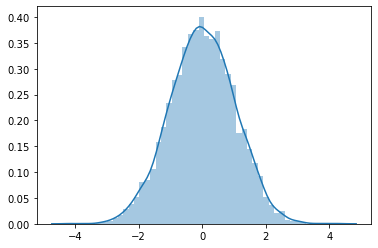

In [18]:
%matplotlib inline
samples = hamiltonian_monte_carlo(5000, potential,
                                  initial_position=np.zeros(1), 
#                                  initial_step_size=0.0001,
#                                  tune=,
#                                 path_len=10,
                                 )
sns.distplot(samples)


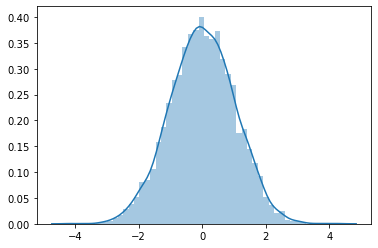

In [19]:
import seaborn as sns                                 
sns.distplot(samples)

# Bayesian inference #

In [20]:
from Experiments.foong import Setup
layerwidth=50
nblayers=1
setup=Setup(device,layerwidth=layerwidth,nblayers=nblayers)

# Target density #

In [22]:
param_count=setup.param_count
logposterior=setup.logposterior



In [37]:
from Inference.PointEstimate import AdamGradientDescent
def _MAP(nbiter, std_init,logposterior, dim, device='cpu'):
        optimizer = AdamGradientDescent(logposterior, nbiter, .01, .00000001, 50, .5, device, True)

        theta0 = torch.empty((1, dim), device=device).normal_(0., std=std_init)
        best_theta, best_score, score = optimizer.run(theta0)

        return best_theta.detach().clone()

theta=_MAP(20000,1., logposterior, param_count)

Epoch [1/20000], Loss: 456905.125, Learning Rate: 0.01
Epoch [2/20000], Loss: 407155.90625, Learning Rate: 0.01
Epoch [3/20000], Loss: 360525.625, Learning Rate: 0.01
Epoch [4/20000], Loss: 317047.90625, Learning Rate: 0.01
Epoch [5/20000], Loss: 276721.84375, Learning Rate: 0.01
Epoch [6/20000], Loss: 239513.921875, Learning Rate: 0.01
Epoch [7/20000], Loss: 205361.203125, Learning Rate: 0.01
Epoch [8/20000], Loss: 174184.78125, Learning Rate: 0.01
Epoch [9/20000], Loss: 145909.28125, Learning Rate: 0.01
Epoch [10/20000], Loss: 120472.125, Learning Rate: 0.01
Epoch [11/20000], Loss: 97819.9140625, Learning Rate: 0.01
Epoch [12/20000], Loss: 77898.6640625, Learning Rate: 0.01
Epoch [13/20000], Loss: 60643.71484375, Learning Rate: 0.01
Epoch [14/20000], Loss: 45970.40625, Learning Rate: 0.01
Epoch [15/20000], Loss: 33767.640625, Learning Rate: 0.01
Epoch [16/20000], Loss: 23894.46484375, Learning Rate: 0.01
Epoch [17/20000], Loss: 16180.939453125, Learning Rate: 0.01
Epoch [18/20000], L

Epoch [195/20000], Loss: 388.2132568359375, Learning Rate: 0.01
Epoch [196/20000], Loss: 385.4100341796875, Learning Rate: 0.01
Epoch [197/20000], Loss: 382.6467590332031, Learning Rate: 0.01
Epoch [198/20000], Loss: 379.92291259765625, Learning Rate: 0.01
Epoch [199/20000], Loss: 377.23785400390625, Learning Rate: 0.01
Epoch [200/20000], Loss: 374.5906982421875, Learning Rate: 0.01
Epoch [201/20000], Loss: 371.9810791015625, Learning Rate: 0.01
Epoch [202/20000], Loss: 369.407958984375, Learning Rate: 0.01
Epoch [203/20000], Loss: 366.870849609375, Learning Rate: 0.01
Epoch [204/20000], Loss: 364.3687744140625, Learning Rate: 0.01
Epoch [205/20000], Loss: 361.90179443359375, Learning Rate: 0.01
Epoch [206/20000], Loss: 359.46820068359375, Learning Rate: 0.01
Epoch [207/20000], Loss: 357.068359375, Learning Rate: 0.01
Epoch [208/20000], Loss: 354.7010498046875, Learning Rate: 0.01
Epoch [209/20000], Loss: 352.3660888671875, Learning Rate: 0.01
Epoch [210/20000], Loss: 350.0630493164062

Epoch [362/20000], Loss: 192.1509246826172, Learning Rate: 0.01
Epoch [363/20000], Loss: 191.76792907714844, Learning Rate: 0.01
Epoch [364/20000], Loss: 191.38894653320312, Learning Rate: 0.01
Epoch [365/20000], Loss: 191.01400756835938, Learning Rate: 0.01
Epoch [366/20000], Loss: 190.64317321777344, Learning Rate: 0.01
Epoch [367/20000], Loss: 190.27630615234375, Learning Rate: 0.01
Epoch [368/20000], Loss: 189.913330078125, Learning Rate: 0.01
Epoch [369/20000], Loss: 189.55398559570312, Learning Rate: 0.01
Epoch [370/20000], Loss: 189.19882202148438, Learning Rate: 0.01
Epoch [371/20000], Loss: 188.8473358154297, Learning Rate: 0.01
Epoch [372/20000], Loss: 188.49957275390625, Learning Rate: 0.01
Epoch [373/20000], Loss: 188.15538024902344, Learning Rate: 0.01
Epoch [374/20000], Loss: 187.815185546875, Learning Rate: 0.01
Epoch [375/20000], Loss: 187.4782257080078, Learning Rate: 0.01
Epoch [376/20000], Loss: 187.14483642578125, Learning Rate: 0.01
Epoch [377/20000], Loss: 186.815

Epoch [543/20000], Loss: 158.1256103515625, Learning Rate: 0.01
Epoch [544/20000], Loss: 158.02713012695312, Learning Rate: 0.01
Epoch [545/20000], Loss: 157.92922973632812, Learning Rate: 0.01
Epoch [546/20000], Loss: 157.83108520507812, Learning Rate: 0.01
Epoch [547/20000], Loss: 157.73390197753906, Learning Rate: 0.01
Epoch [548/20000], Loss: 157.63670349121094, Learning Rate: 0.01
Epoch [549/20000], Loss: 157.53985595703125, Learning Rate: 0.01
Epoch [550/20000], Loss: 157.44358825683594, Learning Rate: 0.01
Epoch [551/20000], Loss: 157.3472900390625, Learning Rate: 0.01
Epoch [552/20000], Loss: 157.25140380859375, Learning Rate: 0.01
Epoch [553/20000], Loss: 157.15533447265625, Learning Rate: 0.01
Epoch [554/20000], Loss: 157.06019592285156, Learning Rate: 0.01
Epoch [555/20000], Loss: 156.9654083251953, Learning Rate: 0.01
Epoch [556/20000], Loss: 156.87063598632812, Learning Rate: 0.01
Epoch [557/20000], Loss: 156.776123046875, Learning Rate: 0.01
Epoch [558/20000], Loss: 156.6

Epoch [730/20000], Loss: 142.1435546875, Learning Rate: 0.01
Epoch [731/20000], Loss: 142.06045532226562, Learning Rate: 0.01
Epoch [732/20000], Loss: 141.97756958007812, Learning Rate: 0.01
Epoch [733/20000], Loss: 141.89437866210938, Learning Rate: 0.01
Epoch [734/20000], Loss: 141.811279296875, Learning Rate: 0.01
Epoch [735/20000], Loss: 141.728271484375, Learning Rate: 0.01
Epoch [736/20000], Loss: 141.64508056640625, Learning Rate: 0.01
Epoch [737/20000], Loss: 141.56192016601562, Learning Rate: 0.01
Epoch [738/20000], Loss: 141.47854614257812, Learning Rate: 0.01
Epoch [739/20000], Loss: 141.39512634277344, Learning Rate: 0.01
Epoch [740/20000], Loss: 141.31192016601562, Learning Rate: 0.01
Epoch [741/20000], Loss: 141.22872924804688, Learning Rate: 0.01
Epoch [742/20000], Loss: 141.14505004882812, Learning Rate: 0.01
Epoch [743/20000], Loss: 141.061767578125, Learning Rate: 0.01
Epoch [744/20000], Loss: 140.97848510742188, Learning Rate: 0.01
Epoch [745/20000], Loss: 140.894760

Epoch [908/20000], Loss: 127.09632873535156, Learning Rate: 0.01
Epoch [909/20000], Loss: 127.01425170898438, Learning Rate: 0.01
Epoch [910/20000], Loss: 126.9324951171875, Learning Rate: 0.01
Epoch [911/20000], Loss: 126.85049438476562, Learning Rate: 0.01
Epoch [912/20000], Loss: 126.76864624023438, Learning Rate: 0.01
Epoch [913/20000], Loss: 126.68724060058594, Learning Rate: 0.01
Epoch [914/20000], Loss: 126.6056137084961, Learning Rate: 0.01
Epoch [915/20000], Loss: 126.52405548095703, Learning Rate: 0.01
Epoch [916/20000], Loss: 126.44282531738281, Learning Rate: 0.01
Epoch [917/20000], Loss: 126.36116790771484, Learning Rate: 0.01
Epoch [918/20000], Loss: 126.2802734375, Learning Rate: 0.01
Epoch [919/20000], Loss: 126.19922637939453, Learning Rate: 0.01
Epoch [920/20000], Loss: 126.1181869506836, Learning Rate: 0.01
Epoch [921/20000], Loss: 126.03742218017578, Learning Rate: 0.01
Epoch [922/20000], Loss: 125.95663452148438, Learning Rate: 0.01
Epoch [923/20000], Loss: 125.875

Epoch [1106/20000], Loss: 113.21089172363281, Learning Rate: 0.01
Epoch [1107/20000], Loss: 113.15302276611328, Learning Rate: 0.01
Epoch [1108/20000], Loss: 113.09517669677734, Learning Rate: 0.01
Epoch [1109/20000], Loss: 113.03741455078125, Learning Rate: 0.01
Epoch [1110/20000], Loss: 112.97972106933594, Learning Rate: 0.01
Epoch [1111/20000], Loss: 112.92222595214844, Learning Rate: 0.01
Epoch [1112/20000], Loss: 112.86466979980469, Learning Rate: 0.01
Epoch [1113/20000], Loss: 112.80742645263672, Learning Rate: 0.01
Epoch [1114/20000], Loss: 112.7500228881836, Learning Rate: 0.01
Epoch [1115/20000], Loss: 112.69306945800781, Learning Rate: 0.01
Epoch [1116/20000], Loss: 112.6359634399414, Learning Rate: 0.01
Epoch [1117/20000], Loss: 112.5791015625, Learning Rate: 0.01
Epoch [1118/20000], Loss: 112.52220916748047, Learning Rate: 0.01
Epoch [1119/20000], Loss: 112.46556091308594, Learning Rate: 0.01
Epoch [1120/20000], Loss: 112.40900421142578, Learning Rate: 0.01
Epoch [1121/2000

Epoch [1248/20000], Loss: 105.84867858886719, Learning Rate: 0.01
Epoch [1249/20000], Loss: 105.80169677734375, Learning Rate: 0.01
Epoch [1250/20000], Loss: 105.75497436523438, Learning Rate: 0.01
Epoch [1251/20000], Loss: 105.70807647705078, Learning Rate: 0.01
Epoch [1252/20000], Loss: 105.66155242919922, Learning Rate: 0.01
Epoch [1253/20000], Loss: 105.61490631103516, Learning Rate: 0.01
Epoch [1254/20000], Loss: 105.56810760498047, Learning Rate: 0.01
Epoch [1255/20000], Loss: 105.52174377441406, Learning Rate: 0.01
Epoch [1256/20000], Loss: 105.4750747680664, Learning Rate: 0.01
Epoch [1257/20000], Loss: 105.42876434326172, Learning Rate: 0.01
Epoch [1258/20000], Loss: 105.38217163085938, Learning Rate: 0.01
Epoch [1259/20000], Loss: 105.33588409423828, Learning Rate: 0.01
Epoch [1260/20000], Loss: 105.28956604003906, Learning Rate: 0.01
Epoch [1261/20000], Loss: 105.2433090209961, Learning Rate: 0.01
Epoch [1262/20000], Loss: 105.19713592529297, Learning Rate: 0.01
Epoch [1263/

Epoch [1380/20000], Loss: 100.0376205444336, Learning Rate: 0.01
Epoch [1381/20000], Loss: 99.99588775634766, Learning Rate: 0.01
Epoch [1382/20000], Loss: 99.95413970947266, Learning Rate: 0.01
Epoch [1383/20000], Loss: 99.91216278076172, Learning Rate: 0.01
Epoch [1384/20000], Loss: 99.87068176269531, Learning Rate: 0.01
Epoch [1385/20000], Loss: 99.8290023803711, Learning Rate: 0.01
Epoch [1386/20000], Loss: 99.78758239746094, Learning Rate: 0.01
Epoch [1387/20000], Loss: 99.74591064453125, Learning Rate: 0.01
Epoch [1388/20000], Loss: 99.70425415039062, Learning Rate: 0.01
Epoch [1389/20000], Loss: 99.66297149658203, Learning Rate: 0.01
Epoch [1390/20000], Loss: 99.62126159667969, Learning Rate: 0.01
Epoch [1391/20000], Loss: 99.57980346679688, Learning Rate: 0.01
Epoch [1392/20000], Loss: 99.53874206542969, Learning Rate: 0.01
Epoch [1393/20000], Loss: 99.49700164794922, Learning Rate: 0.01
Epoch [1394/20000], Loss: 99.45584106445312, Learning Rate: 0.01
Epoch [1395/20000], Loss: 

Epoch [1507/20000], Loss: 94.91923522949219, Learning Rate: 0.01
Epoch [1508/20000], Loss: 94.88014221191406, Learning Rate: 0.01
Epoch [1509/20000], Loss: 94.8409652709961, Learning Rate: 0.01
Epoch [1510/20000], Loss: 94.80200958251953, Learning Rate: 0.01
Epoch [1511/20000], Loss: 94.76275634765625, Learning Rate: 0.01
Epoch [1512/20000], Loss: 94.72386932373047, Learning Rate: 0.01
Epoch [1513/20000], Loss: 94.68489837646484, Learning Rate: 0.01
Epoch [1514/20000], Loss: 94.64582824707031, Learning Rate: 0.01
Epoch [1515/20000], Loss: 94.60679626464844, Learning Rate: 0.01
Epoch [1516/20000], Loss: 94.56790161132812, Learning Rate: 0.01
Epoch [1517/20000], Loss: 94.5289535522461, Learning Rate: 0.01
Epoch [1518/20000], Loss: 94.4899673461914, Learning Rate: 0.01
Epoch [1519/20000], Loss: 94.45111083984375, Learning Rate: 0.01
Epoch [1520/20000], Loss: 94.41213989257812, Learning Rate: 0.01
Epoch [1521/20000], Loss: 94.37332153320312, Learning Rate: 0.01
Epoch [1522/20000], Loss: 94

Epoch [1635/20000], Loss: 90.03125, Learning Rate: 0.01
Epoch [1636/20000], Loss: 89.99372863769531, Learning Rate: 0.01
Epoch [1637/20000], Loss: 89.95624542236328, Learning Rate: 0.01
Epoch [1638/20000], Loss: 89.91907501220703, Learning Rate: 0.01
Epoch [1639/20000], Loss: 89.88175964355469, Learning Rate: 0.01
Epoch [1640/20000], Loss: 89.84445190429688, Learning Rate: 0.01
Epoch [1641/20000], Loss: 89.80744171142578, Learning Rate: 0.01
Epoch [1642/20000], Loss: 89.76991271972656, Learning Rate: 0.01
Epoch [1643/20000], Loss: 89.73278045654297, Learning Rate: 0.01
Epoch [1644/20000], Loss: 89.69544219970703, Learning Rate: 0.01
Epoch [1645/20000], Loss: 89.65821838378906, Learning Rate: 0.01
Epoch [1646/20000], Loss: 89.62100219726562, Learning Rate: 0.01
Epoch [1647/20000], Loss: 89.58377838134766, Learning Rate: 0.01
Epoch [1648/20000], Loss: 89.5467300415039, Learning Rate: 0.01
Epoch [1649/20000], Loss: 89.50936889648438, Learning Rate: 0.01
Epoch [1650/20000], Loss: 89.472114

Epoch [1764/20000], Loss: 85.31523132324219, Learning Rate: 0.01
Epoch [1765/20000], Loss: 85.27952575683594, Learning Rate: 0.01
Epoch [1766/20000], Loss: 85.24369812011719, Learning Rate: 0.01
Epoch [1767/20000], Loss: 85.20803833007812, Learning Rate: 0.01
Epoch [1768/20000], Loss: 85.17228698730469, Learning Rate: 0.01
Epoch [1769/20000], Loss: 85.1363525390625, Learning Rate: 0.01
Epoch [1770/20000], Loss: 85.10067749023438, Learning Rate: 0.01
Epoch [1771/20000], Loss: 85.06500244140625, Learning Rate: 0.01
Epoch [1772/20000], Loss: 85.02926635742188, Learning Rate: 0.01
Epoch [1773/20000], Loss: 84.99392700195312, Learning Rate: 0.01
Epoch [1774/20000], Loss: 84.95816040039062, Learning Rate: 0.01
Epoch [1775/20000], Loss: 84.92247009277344, Learning Rate: 0.01
Epoch [1776/20000], Loss: 84.88677978515625, Learning Rate: 0.01
Epoch [1777/20000], Loss: 84.85124206542969, Learning Rate: 0.01
Epoch [1778/20000], Loss: 84.81553649902344, Learning Rate: 0.01
Epoch [1779/20000], Loss: 

Epoch [1986/20000], Loss: 77.69633483886719, Learning Rate: 0.01
Epoch [1987/20000], Loss: 77.66354370117188, Learning Rate: 0.01
Epoch [1988/20000], Loss: 77.63084411621094, Learning Rate: 0.01
Epoch [1989/20000], Loss: 77.59796142578125, Learning Rate: 0.01
Epoch [1990/20000], Loss: 77.56515502929688, Learning Rate: 0.01
Epoch [1991/20000], Loss: 77.53250122070312, Learning Rate: 0.01
Epoch [1992/20000], Loss: 77.4998779296875, Learning Rate: 0.01
Epoch [1993/20000], Loss: 77.46731567382812, Learning Rate: 0.01
Epoch [1994/20000], Loss: 77.43437194824219, Learning Rate: 0.01
Epoch [1995/20000], Loss: 77.40194702148438, Learning Rate: 0.01
Epoch [1996/20000], Loss: 77.36912536621094, Learning Rate: 0.01
Epoch [1997/20000], Loss: 77.33639526367188, Learning Rate: 0.01
Epoch [1998/20000], Loss: 77.30377197265625, Learning Rate: 0.01
Epoch [1999/20000], Loss: 77.27125549316406, Learning Rate: 0.01
Epoch [2000/20000], Loss: 77.2386474609375, Learning Rate: 0.01
Epoch [2001/20000], Loss: 7

Epoch [2187/20000], Loss: 71.41099548339844, Learning Rate: 0.01
Epoch [2188/20000], Loss: 71.38133239746094, Learning Rate: 0.01
Epoch [2189/20000], Loss: 71.35154724121094, Learning Rate: 0.01
Epoch [2190/20000], Loss: 71.32205200195312, Learning Rate: 0.01
Epoch [2191/20000], Loss: 71.29231262207031, Learning Rate: 0.01
Epoch [2192/20000], Loss: 71.26278686523438, Learning Rate: 0.01
Epoch [2193/20000], Loss: 71.23332214355469, Learning Rate: 0.01
Epoch [2194/20000], Loss: 71.20346069335938, Learning Rate: 0.01
Epoch [2195/20000], Loss: 71.17402648925781, Learning Rate: 0.01
Epoch [2196/20000], Loss: 71.14436340332031, Learning Rate: 0.01
Epoch [2197/20000], Loss: 71.11494445800781, Learning Rate: 0.01
Epoch [2198/20000], Loss: 71.08526611328125, Learning Rate: 0.01
Epoch [2199/20000], Loss: 71.055908203125, Learning Rate: 0.01
Epoch [2200/20000], Loss: 71.02622985839844, Learning Rate: 0.01
Epoch [2201/20000], Loss: 70.99681091308594, Learning Rate: 0.01
Epoch [2202/20000], Loss: 7

Epoch [2393/20000], Loss: 65.633056640625, Learning Rate: 0.01
Epoch [2394/20000], Loss: 65.60658264160156, Learning Rate: 0.01
Epoch [2395/20000], Loss: 65.58038330078125, Learning Rate: 0.01
Epoch [2396/20000], Loss: 65.553955078125, Learning Rate: 0.01
Epoch [2397/20000], Loss: 65.52755737304688, Learning Rate: 0.01
Epoch [2398/20000], Loss: 65.50117492675781, Learning Rate: 0.01
Epoch [2399/20000], Loss: 65.4749755859375, Learning Rate: 0.01
Epoch [2400/20000], Loss: 65.44868469238281, Learning Rate: 0.01
Epoch [2401/20000], Loss: 65.4224853515625, Learning Rate: 0.01
Epoch [2402/20000], Loss: 65.39619445800781, Learning Rate: 0.01
Epoch [2403/20000], Loss: 65.37002563476562, Learning Rate: 0.01
Epoch [2404/20000], Loss: 65.34370422363281, Learning Rate: 0.01
Epoch [2405/20000], Loss: 65.31756591796875, Learning Rate: 0.01
Epoch [2406/20000], Loss: 65.291259765625, Learning Rate: 0.01
Epoch [2407/20000], Loss: 65.26502990722656, Learning Rate: 0.01
Epoch [2408/20000], Loss: 65.2387

Epoch [2625/20000], Loss: 59.92414855957031, Learning Rate: 0.01
Epoch [2626/20000], Loss: 59.90110778808594, Learning Rate: 0.01
Epoch [2627/20000], Loss: 59.878387451171875, Learning Rate: 0.01
Epoch [2628/20000], Loss: 59.85539245605469, Learning Rate: 0.01
Epoch [2629/20000], Loss: 59.83250427246094, Learning Rate: 0.01
Epoch [2630/20000], Loss: 59.80973815917969, Learning Rate: 0.01
Epoch [2631/20000], Loss: 59.7869873046875, Learning Rate: 0.01
Epoch [2632/20000], Loss: 59.76414489746094, Learning Rate: 0.01
Epoch [2633/20000], Loss: 59.741485595703125, Learning Rate: 0.01
Epoch [2634/20000], Loss: 59.71867370605469, Learning Rate: 0.01
Epoch [2635/20000], Loss: 59.6959228515625, Learning Rate: 0.01
Epoch [2636/20000], Loss: 59.6732177734375, Learning Rate: 0.01
Epoch [2637/20000], Loss: 59.650390625, Learning Rate: 0.01
Epoch [2638/20000], Loss: 59.62770080566406, Learning Rate: 0.01
Epoch [2639/20000], Loss: 59.605010986328125, Learning Rate: 0.01
Epoch [2640/20000], Loss: 59.5

Epoch [2754/20000], Loss: 57.0863037109375, Learning Rate: 0.01
Epoch [2755/20000], Loss: 57.06512451171875, Learning Rate: 0.01
Epoch [2756/20000], Loss: 57.04399108886719, Learning Rate: 0.01
Epoch [2757/20000], Loss: 57.02293395996094, Learning Rate: 0.01
Epoch [2758/20000], Loss: 57.001861572265625, Learning Rate: 0.01
Epoch [2759/20000], Loss: 56.980743408203125, Learning Rate: 0.01
Epoch [2760/20000], Loss: 56.95967102050781, Learning Rate: 0.01
Epoch [2761/20000], Loss: 56.93849182128906, Learning Rate: 0.01
Epoch [2762/20000], Loss: 56.91748046875, Learning Rate: 0.01
Epoch [2763/20000], Loss: 56.896484375, Learning Rate: 0.01
Epoch [2764/20000], Loss: 56.87547302246094, Learning Rate: 0.01
Epoch [2765/20000], Loss: 56.854522705078125, Learning Rate: 0.01
Epoch [2766/20000], Loss: 56.83345031738281, Learning Rate: 0.01
Epoch [2767/20000], Loss: 56.81257629394531, Learning Rate: 0.01
Epoch [2768/20000], Loss: 56.79145812988281, Learning Rate: 0.01
Epoch [2769/20000], Loss: 56.77

Epoch [2900/20000], Loss: 54.13069152832031, Learning Rate: 0.01
Epoch [2901/20000], Loss: 54.1116943359375, Learning Rate: 0.01
Epoch [2902/20000], Loss: 54.09199523925781, Learning Rate: 0.01
Epoch [2903/20000], Loss: 54.07206726074219, Learning Rate: 0.01
Epoch [2904/20000], Loss: 54.05259704589844, Learning Rate: 0.01
Epoch [2905/20000], Loss: 54.03318786621094, Learning Rate: 0.01
Epoch [2906/20000], Loss: 54.01387023925781, Learning Rate: 0.01
Epoch [2907/20000], Loss: 53.994781494140625, Learning Rate: 0.01
Epoch [2908/20000], Loss: 53.975830078125, Learning Rate: 0.01
Epoch [2909/20000], Loss: 53.95625305175781, Learning Rate: 0.01
Epoch [2910/20000], Loss: 53.9368896484375, Learning Rate: 0.01
Epoch [2911/20000], Loss: 53.91734313964844, Learning Rate: 0.01
Epoch [2912/20000], Loss: 53.89788818359375, Learning Rate: 0.01
Epoch [2913/20000], Loss: 53.878662109375, Learning Rate: 0.01
Epoch [2914/20000], Loss: 53.85948181152344, Learning Rate: 0.01
Epoch [2915/20000], Loss: 53.8

Epoch [3043/20000], Loss: 51.46891784667969, Learning Rate: 0.01
Epoch [3044/20000], Loss: 51.453460693359375, Learning Rate: 0.01
Epoch [3045/20000], Loss: 51.43922424316406, Learning Rate: 0.01
Epoch [3046/20000], Loss: 51.42662048339844, Learning Rate: 0.01
Epoch [3047/20000], Loss: 51.41520690917969, Learning Rate: 0.01
Epoch [3048/20000], Loss: 51.40415954589844, Learning Rate: 0.01
Epoch [3049/20000], Loss: 51.39030456542969, Learning Rate: 0.01
Epoch [3050/20000], Loss: 51.371124267578125, Learning Rate: 0.01
Epoch [3051/20000], Loss: 51.345489501953125, Learning Rate: 0.01
Epoch [3052/20000], Loss: 51.31634521484375, Learning Rate: 0.01
Epoch [3053/20000], Loss: 51.28887939453125, Learning Rate: 0.01
Epoch [3054/20000], Loss: 51.26774597167969, Learning Rate: 0.01
Epoch [3055/20000], Loss: 51.252777099609375, Learning Rate: 0.01
Epoch [3056/20000], Loss: 51.24076843261719, Learning Rate: 0.01
Epoch [3057/20000], Loss: 51.22718811035156, Learning Rate: 0.01
Epoch [3058/20000], L

Epoch [3199/20000], Loss: 48.77684020996094, Learning Rate: 0.01
Epoch [3200/20000], Loss: 48.76043701171875, Learning Rate: 0.01
Epoch [3201/20000], Loss: 48.743804931640625, Learning Rate: 0.01
Epoch [3202/20000], Loss: 48.72706604003906, Learning Rate: 0.01
Epoch [3203/20000], Loss: 48.71070861816406, Learning Rate: 0.01
Epoch [3204/20000], Loss: 48.694183349609375, Learning Rate: 0.01
Epoch [3205/20000], Loss: 48.67755126953125, Learning Rate: 0.01
Epoch [3206/20000], Loss: 48.66119384765625, Learning Rate: 0.01
Epoch [3207/20000], Loss: 48.64445495605469, Learning Rate: 0.01
Epoch [3208/20000], Loss: 48.62809753417969, Learning Rate: 0.01
Epoch [3209/20000], Loss: 48.61158752441406, Learning Rate: 0.01
Epoch [3210/20000], Loss: 48.594940185546875, Learning Rate: 0.01
Epoch [3211/20000], Loss: 48.57861328125, Learning Rate: 0.01
Epoch [3212/20000], Loss: 48.561981201171875, Learning Rate: 0.01
Epoch [3213/20000], Loss: 48.54563903808594, Learning Rate: 0.01
Epoch [3214/20000], Loss

Epoch [3331/20000], Loss: 46.65391540527344, Learning Rate: 0.01
Epoch [3332/20000], Loss: 46.63836669921875, Learning Rate: 0.01
Epoch [3333/20000], Loss: 46.62278747558594, Learning Rate: 0.01
Epoch [3334/20000], Loss: 46.6070556640625, Learning Rate: 0.01
Epoch [3335/20000], Loss: 46.59144592285156, Learning Rate: 0.01
Epoch [3336/20000], Loss: 46.575775146484375, Learning Rate: 0.01
Epoch [3337/20000], Loss: 46.560028076171875, Learning Rate: 0.01
Epoch [3338/20000], Loss: 46.544647216796875, Learning Rate: 0.01
Epoch [3339/20000], Loss: 46.52911376953125, Learning Rate: 0.01
Epoch [3340/20000], Loss: 46.513671875, Learning Rate: 0.01
Epoch [3341/20000], Loss: 46.49806213378906, Learning Rate: 0.01
Epoch [3342/20000], Loss: 46.482421875, Learning Rate: 0.01
Epoch [3343/20000], Loss: 46.46696472167969, Learning Rate: 0.01
Epoch [3344/20000], Loss: 46.45143127441406, Learning Rate: 0.01
Epoch [3345/20000], Loss: 46.43583679199219, Learning Rate: 0.01
Epoch [3346/20000], Loss: 46.4203

Epoch [3459/20000], Loss: 44.70719909667969, Learning Rate: 0.01
Epoch [3460/20000], Loss: 44.69261169433594, Learning Rate: 0.01
Epoch [3461/20000], Loss: 44.677886962890625, Learning Rate: 0.01
Epoch [3462/20000], Loss: 44.662506103515625, Learning Rate: 0.01
Epoch [3463/20000], Loss: 44.64723205566406, Learning Rate: 0.01
Epoch [3464/20000], Loss: 44.631988525390625, Learning Rate: 0.01
Epoch [3465/20000], Loss: 44.61689758300781, Learning Rate: 0.01
Epoch [3466/20000], Loss: 44.60206604003906, Learning Rate: 0.01
Epoch [3467/20000], Loss: 44.58734130859375, Learning Rate: 0.01
Epoch [3468/20000], Loss: 44.57267761230469, Learning Rate: 0.01
Epoch [3469/20000], Loss: 44.55815124511719, Learning Rate: 0.01
Epoch [3470/20000], Loss: 44.54351806640625, Learning Rate: 0.01
Epoch [3471/20000], Loss: 44.52870178222656, Learning Rate: 0.01
Epoch [3472/20000], Loss: 44.513671875, Learning Rate: 0.01
Epoch [3473/20000], Loss: 44.49894714355469, Learning Rate: 0.01
Epoch [3474/20000], Loss: 4

Epoch [3650/20000], Loss: 41.96485900878906, Learning Rate: 0.01
Epoch [3651/20000], Loss: 41.95111083984375, Learning Rate: 0.01
Epoch [3652/20000], Loss: 41.93707275390625, Learning Rate: 0.01
Epoch [3653/20000], Loss: 41.92326354980469, Learning Rate: 0.01
Epoch [3654/20000], Loss: 41.90953063964844, Learning Rate: 0.01
Epoch [3655/20000], Loss: 41.8955078125, Learning Rate: 0.01
Epoch [3656/20000], Loss: 41.881683349609375, Learning Rate: 0.01
Epoch [3657/20000], Loss: 41.867767333984375, Learning Rate: 0.01
Epoch [3658/20000], Loss: 41.85400390625, Learning Rate: 0.01
Epoch [3659/20000], Loss: 41.84014892578125, Learning Rate: 0.01
Epoch [3660/20000], Loss: 41.82646179199219, Learning Rate: 0.01
Epoch [3661/20000], Loss: 41.81239318847656, Learning Rate: 0.01
Epoch [3662/20000], Loss: 41.798675537109375, Learning Rate: 0.01
Epoch [3663/20000], Loss: 41.784881591796875, Learning Rate: 0.01
Epoch [3664/20000], Loss: 41.77117919921875, Learning Rate: 0.01
Epoch [3665/20000], Loss: 41

Epoch [3841/20000], Loss: 40.06529235839844, Learning Rate: 0.01
Epoch [3842/20000], Loss: 39.63926696777344, Learning Rate: 0.01
Epoch [3843/20000], Loss: 39.380950927734375, Learning Rate: 0.01
Epoch [3844/20000], Loss: 39.38665771484375, Learning Rate: 0.01
Epoch [3845/20000], Loss: 39.57171630859375, Learning Rate: 0.01
Epoch [3846/20000], Loss: 39.75733947753906, Learning Rate: 0.01
Epoch [3847/20000], Loss: 39.79901123046875, Learning Rate: 0.01
Epoch [3848/20000], Loss: 39.67027282714844, Learning Rate: 0.01
Epoch [3849/20000], Loss: 39.460601806640625, Learning Rate: 0.01
Epoch [3850/20000], Loss: 39.298248291015625, Learning Rate: 0.01
Epoch [3851/20000], Loss: 39.25843811035156, Learning Rate: 0.01
Epoch [3852/20000], Loss: 39.324066162109375, Learning Rate: 0.01
Epoch [3853/20000], Loss: 39.41410827636719, Learning Rate: 0.01
Epoch [3854/20000], Loss: 39.4490966796875, Learning Rate: 0.01
Epoch [3855/20000], Loss: 39.39973449707031, Learning Rate: 0.01
Epoch [3856/20000], Lo

Epoch [4031/20000], Loss: 37.12158203125, Learning Rate: 0.01
Epoch [4032/20000], Loss: 37.83766174316406, Learning Rate: 0.01
Epoch [4033/20000], Loss: 38.54487609863281, Learning Rate: 0.01
Epoch [4034/20000], Loss: 38.719970703125, Learning Rate: 0.01
Epoch [4035/20000], Loss: 38.25347900390625, Learning Rate: 0.01
Epoch [4036/20000], Loss: 37.49165344238281, Learning Rate: 0.01
Epoch [4037/20000], Loss: 36.95024108886719, Learning Rate: 0.01
Epoch [4038/20000], Loss: 36.912078857421875, Learning Rate: 0.01
Epoch [4039/20000], Loss: 37.254241943359375, Learning Rate: 0.01
Epoch [4040/20000], Loss: 37.611724853515625, Learning Rate: 0.01
Epoch [4041/20000], Loss: 37.676910400390625, Learning Rate: 0.01
Epoch [4042/20000], Loss: 37.410797119140625, Learning Rate: 0.01
Epoch [4043/20000], Loss: 37.028472900390625, Learning Rate: 0.01
Epoch [4044/20000], Loss: 36.79866027832031, Learning Rate: 0.01
Epoch [4045/20000], Loss: 36.82904052734375, Learning Rate: 0.01
Epoch [4046/20000], Loss

Epoch [4242/20000], Loss: 35.14439392089844, Learning Rate: 0.01
Epoch [4243/20000], Loss: 35.584197998046875, Learning Rate: 0.01
Epoch [4244/20000], Loss: 36.2576904296875, Learning Rate: 0.01
Epoch [4245/20000], Loss: 37.234039306640625, Learning Rate: 0.01
Epoch [4246/20000], Loss: 38.527435302734375, Learning Rate: 0.01
Epoch [4247/20000], Loss: 39.98638916015625, Learning Rate: 0.01
Epoch [4248/20000], Loss: 41.17022705078125, Learning Rate: 0.01
Epoch [4249/20000], Loss: 41.37762451171875, Learning Rate: 0.01
Epoch [4250/20000], Loss: 40.08660888671875, Learning Rate: 0.01
Epoch [4251/20000], Loss: 37.62327575683594, Learning Rate: 0.01
Epoch [4252/20000], Loss: 35.25157165527344, Learning Rate: 0.01
Epoch [4253/20000], Loss: 34.23834228515625, Learning Rate: 0.01
Epoch [4254/20000], Loss: 34.82701110839844, Learning Rate: 0.01
Epoch [4255/20000], Loss: 36.17047119140625, Learning Rate: 0.01
Epoch [4256/20000], Loss: 37.06248474121094, Learning Rate: 0.01
Epoch [4257/20000], Los

Epoch [4466/20000], Loss: 31.739089965820312, Learning Rate: 0.01
Epoch [4467/20000], Loss: 31.72760009765625, Learning Rate: 0.01
Epoch [4468/20000], Loss: 31.715957641601562, Learning Rate: 0.01
Epoch [4469/20000], Loss: 31.704757690429688, Learning Rate: 0.01
Epoch [4470/20000], Loss: 31.693161010742188, Learning Rate: 0.01
Epoch [4471/20000], Loss: 31.681732177734375, Learning Rate: 0.01
Epoch [4472/20000], Loss: 31.670196533203125, Learning Rate: 0.01
Epoch [4473/20000], Loss: 31.6590576171875, Learning Rate: 0.01
Epoch [4474/20000], Loss: 31.647796630859375, Learning Rate: 0.01
Epoch [4475/20000], Loss: 31.636932373046875, Learning Rate: 0.01
Epoch [4476/20000], Loss: 31.626007080078125, Learning Rate: 0.01
Epoch [4477/20000], Loss: 31.61578369140625, Learning Rate: 0.01
Epoch [4478/20000], Loss: 31.605804443359375, Learning Rate: 0.01
Epoch [4479/20000], Loss: 31.596878051757812, Learning Rate: 0.01
Epoch [4480/20000], Loss: 31.5894775390625, Learning Rate: 0.01
Epoch [4481/2000

Epoch [4600/20000], Loss: 30.213226318359375, Learning Rate: 0.01
Epoch [4601/20000], Loss: 30.202041625976562, Learning Rate: 0.01
Epoch [4602/20000], Loss: 30.190811157226562, Learning Rate: 0.01
Epoch [4603/20000], Loss: 30.17962646484375, Learning Rate: 0.01
Epoch [4604/20000], Loss: 30.1685791015625, Learning Rate: 0.01
Epoch [4605/20000], Loss: 30.157302856445312, Learning Rate: 0.01
Epoch [4606/20000], Loss: 30.146041870117188, Learning Rate: 0.01
Epoch [4607/20000], Loss: 30.134780883789062, Learning Rate: 0.01
Epoch [4608/20000], Loss: 30.123550415039062, Learning Rate: 0.01
Epoch [4609/20000], Loss: 30.112335205078125, Learning Rate: 0.01
Epoch [4610/20000], Loss: 30.101211547851562, Learning Rate: 0.01
Epoch [4611/20000], Loss: 30.09002685546875, Learning Rate: 0.01
Epoch [4612/20000], Loss: 30.078704833984375, Learning Rate: 0.01
Epoch [4613/20000], Loss: 30.067428588867188, Learning Rate: 0.01
Epoch [4614/20000], Loss: 30.0562744140625, Learning Rate: 0.01
Epoch [4615/2000

Epoch [4758/20000], Loss: 29.470916748046875, Learning Rate: 0.01
Epoch [4759/20000], Loss: 29.098419189453125, Learning Rate: 0.01
Epoch [4760/20000], Loss: 28.616119384765625, Learning Rate: 0.01
Epoch [4761/20000], Loss: 28.415435791015625, Learning Rate: 0.01
Epoch [4762/20000], Loss: 28.5721435546875, Learning Rate: 0.01
Epoch [4763/20000], Loss: 28.841796875, Learning Rate: 0.01
Epoch [4764/20000], Loss: 28.931686401367188, Learning Rate: 0.01
Epoch [4765/20000], Loss: 28.762893676757812, Learning Rate: 0.01
Epoch [4766/20000], Loss: 28.497238159179688, Learning Rate: 0.01
Epoch [4767/20000], Loss: 28.351760864257812, Learning Rate: 0.01
Epoch [4768/20000], Loss: 28.401290893554688, Learning Rate: 0.01
Epoch [4769/20000], Loss: 28.53961181640625, Learning Rate: 0.01
Epoch [4770/20000], Loss: 28.607955932617188, Learning Rate: 0.01
Epoch [4771/20000], Loss: 28.538238525390625, Learning Rate: 0.01
Epoch [4772/20000], Loss: 28.394271850585938, Learning Rate: 0.01
Epoch [4773/20000],

Epoch [4884/20000], Loss: 27.0802001953125, Learning Rate: 0.01
Epoch [4885/20000], Loss: 27.069198608398438, Learning Rate: 0.01
Epoch [4886/20000], Loss: 27.058441162109375, Learning Rate: 0.01
Epoch [4887/20000], Loss: 27.047653198242188, Learning Rate: 0.01
Epoch [4888/20000], Loss: 27.03692626953125, Learning Rate: 0.01
Epoch [4889/20000], Loss: 27.02593994140625, Learning Rate: 0.01
Epoch [4890/20000], Loss: 27.015365600585938, Learning Rate: 0.01
Epoch [4891/20000], Loss: 27.004425048828125, Learning Rate: 0.01
Epoch [4892/20000], Loss: 26.9937744140625, Learning Rate: 0.01
Epoch [4893/20000], Loss: 26.982650756835938, Learning Rate: 0.01
Epoch [4894/20000], Loss: 26.97198486328125, Learning Rate: 0.01
Epoch [4895/20000], Loss: 26.96124267578125, Learning Rate: 0.01
Epoch [4896/20000], Loss: 26.950393676757812, Learning Rate: 0.01
Epoch [4897/20000], Loss: 26.939666748046875, Learning Rate: 0.01
Epoch [4898/20000], Loss: 26.92889404296875, Learning Rate: 0.01
Epoch [4899/20000],

Epoch [5010/20000], Loss: 28.25006103515625, Learning Rate: 0.01
Epoch [5011/20000], Loss: 26.642486572265625, Learning Rate: 0.01
Epoch [5012/20000], Loss: 25.714157104492188, Learning Rate: 0.01
Epoch [5013/20000], Loss: 26.124893188476562, Learning Rate: 0.01
Epoch [5014/20000], Loss: 27.080368041992188, Learning Rate: 0.01
Epoch [5015/20000], Loss: 27.3974609375, Learning Rate: 0.01
Epoch [5016/20000], Loss: 26.761932373046875, Learning Rate: 0.01
Epoch [5017/20000], Loss: 25.90093994140625, Learning Rate: 0.01
Epoch [5018/20000], Loss: 25.65093994140625, Learning Rate: 0.01
Epoch [5019/20000], Loss: 26.071517944335938, Learning Rate: 0.01
Epoch [5020/20000], Loss: 26.529342651367188, Learning Rate: 0.01
Epoch [5021/20000], Loss: 26.477981567382812, Learning Rate: 0.01
Epoch [5022/20000], Loss: 26.002700805664062, Learning Rate: 0.01
Epoch [5023/20000], Loss: 25.615509033203125, Learning Rate: 0.01
Epoch [5024/20000], Loss: 25.646087646484375, Learning Rate: 0.01
Epoch [5025/20000]

Epoch [5135/20000], Loss: 24.408950805664062, Learning Rate: 0.01
Epoch [5136/20000], Loss: 24.398468017578125, Learning Rate: 0.01
Epoch [5137/20000], Loss: 24.388153076171875, Learning Rate: 0.01
Epoch [5138/20000], Loss: 24.37762451171875, Learning Rate: 0.01
Epoch [5139/20000], Loss: 24.367202758789062, Learning Rate: 0.01
Epoch [5140/20000], Loss: 24.356735229492188, Learning Rate: 0.01
Epoch [5141/20000], Loss: 24.346450805664062, Learning Rate: 0.01
Epoch [5142/20000], Loss: 24.335861206054688, Learning Rate: 0.01
Epoch [5143/20000], Loss: 24.325546264648438, Learning Rate: 0.01
Epoch [5144/20000], Loss: 24.315017700195312, Learning Rate: 0.01
Epoch [5145/20000], Loss: 24.30450439453125, Learning Rate: 0.01
Epoch [5146/20000], Loss: 24.294189453125, Learning Rate: 0.01
Epoch [5147/20000], Loss: 24.283889770507812, Learning Rate: 0.01
Epoch [5148/20000], Loss: 24.273452758789062, Learning Rate: 0.01
Epoch [5149/20000], Loss: 24.262832641601562, Learning Rate: 0.01
Epoch [5150/200

Epoch [5263/20000], Loss: 23.0830078125, Learning Rate: 0.01
Epoch [5264/20000], Loss: 23.076126098632812, Learning Rate: 0.01
Epoch [5265/20000], Loss: 23.071121215820312, Learning Rate: 0.01
Epoch [5266/20000], Loss: 23.068893432617188, Learning Rate: 0.01
Epoch [5267/20000], Loss: 23.071044921875, Learning Rate: 0.01
Epoch [5268/20000], Loss: 23.079849243164062, Learning Rate: 0.01
Epoch [5269/20000], Loss: 23.099197387695312, Learning Rate: 0.01
Epoch [5270/20000], Loss: 23.134994506835938, Learning Rate: 0.01
Epoch [5271/20000], Loss: 23.197235107421875, Learning Rate: 0.01
Epoch [5272/20000], Loss: 23.299850463867188, Learning Rate: 0.01
Epoch [5273/20000], Loss: 23.466903686523438, Learning Rate: 0.01
Epoch [5274/20000], Loss: 23.733963012695312, Learning Rate: 0.01
Epoch [5275/20000], Loss: 24.15570068359375, Learning Rate: 0.01
Epoch [5276/20000], Loss: 24.810516357421875, Learning Rate: 0.01
Epoch [5277/20000], Loss: 25.802536010742188, Learning Rate: 0.01
Epoch [5278/20000],

Epoch [5397/20000], Loss: 21.702056884765625, Learning Rate: 0.01
Epoch [5398/20000], Loss: 21.692001342773438, Learning Rate: 0.01
Epoch [5399/20000], Loss: 21.681838989257812, Learning Rate: 0.01
Epoch [5400/20000], Loss: 21.671676635742188, Learning Rate: 0.01
Epoch [5401/20000], Loss: 21.661575317382812, Learning Rate: 0.01
Epoch [5402/20000], Loss: 21.6513671875, Learning Rate: 0.01
Epoch [5403/20000], Loss: 21.641189575195312, Learning Rate: 0.01
Epoch [5404/20000], Loss: 21.631195068359375, Learning Rate: 0.01
Epoch [5405/20000], Loss: 21.621109008789062, Learning Rate: 0.01
Epoch [5406/20000], Loss: 21.610916137695312, Learning Rate: 0.01
Epoch [5407/20000], Loss: 21.600830078125, Learning Rate: 0.01
Epoch [5408/20000], Loss: 21.590652465820312, Learning Rate: 0.01
Epoch [5409/20000], Loss: 21.5804443359375, Learning Rate: 0.01
Epoch [5410/20000], Loss: 21.570281982421875, Learning Rate: 0.01
Epoch [5411/20000], Loss: 21.560256958007812, Learning Rate: 0.01
Epoch [5412/20000], 

Epoch [5541/20000], Loss: 20.624237060546875, Learning Rate: 0.01
Epoch [5542/20000], Loss: 22.057174682617188, Learning Rate: 0.01
Epoch [5543/20000], Loss: 23.103408813476562, Learning Rate: 0.01
Epoch [5544/20000], Loss: 22.797836303710938, Learning Rate: 0.01
Epoch [5545/20000], Loss: 21.4991455078125, Learning Rate: 0.01
Epoch [5546/20000], Loss: 20.381683349609375, Learning Rate: 0.01
Epoch [5547/20000], Loss: 20.269912719726562, Learning Rate: 0.01
Epoch [5548/20000], Loss: 20.966552734375, Learning Rate: 0.01
Epoch [5549/20000], Loss: 21.61541748046875, Learning Rate: 0.01
Epoch [5550/20000], Loss: 21.5689697265625, Learning Rate: 0.01
Epoch [5551/20000], Loss: 20.915420532226562, Learning Rate: 0.01
Epoch [5552/20000], Loss: 20.274459838867188, Learning Rate: 0.01
Epoch [5553/20000], Loss: 20.146011352539062, Learning Rate: 0.01
Epoch [5554/20000], Loss: 20.486968994140625, Learning Rate: 0.01
Epoch [5555/20000], Loss: 20.851181030273438, Learning Rate: 0.01
Epoch [5556/20000]

Epoch [5717/20000], Loss: 18.505767822265625, Learning Rate: 0.01
Epoch [5718/20000], Loss: 18.495681762695312, Learning Rate: 0.01
Epoch [5719/20000], Loss: 18.485977172851562, Learning Rate: 0.01
Epoch [5720/20000], Loss: 18.47607421875, Learning Rate: 0.01
Epoch [5721/20000], Loss: 18.46624755859375, Learning Rate: 0.01
Epoch [5722/20000], Loss: 18.456344604492188, Learning Rate: 0.01
Epoch [5723/20000], Loss: 18.446578979492188, Learning Rate: 0.01
Epoch [5724/20000], Loss: 18.436981201171875, Learning Rate: 0.01
Epoch [5725/20000], Loss: 18.426986694335938, Learning Rate: 0.01
Epoch [5726/20000], Loss: 18.417205810546875, Learning Rate: 0.01
Epoch [5727/20000], Loss: 18.407455444335938, Learning Rate: 0.01
Epoch [5728/20000], Loss: 18.397476196289062, Learning Rate: 0.01
Epoch [5729/20000], Loss: 18.387588500976562, Learning Rate: 0.01
Epoch [5730/20000], Loss: 18.377883911132812, Learning Rate: 0.01
Epoch [5731/20000], Loss: 18.36798095703125, Learning Rate: 0.01
Epoch [5732/2000

Epoch [5925/20000], Loss: 16.493560791015625, Learning Rate: 0.01
Epoch [5926/20000], Loss: 16.48419189453125, Learning Rate: 0.01
Epoch [5927/20000], Loss: 16.474563598632812, Learning Rate: 0.01
Epoch [5928/20000], Loss: 16.4652099609375, Learning Rate: 0.01
Epoch [5929/20000], Loss: 16.455734252929688, Learning Rate: 0.01
Epoch [5930/20000], Loss: 16.446243286132812, Learning Rate: 0.01
Epoch [5931/20000], Loss: 16.436614990234375, Learning Rate: 0.01
Epoch [5932/20000], Loss: 16.427352905273438, Learning Rate: 0.01
Epoch [5933/20000], Loss: 16.41778564453125, Learning Rate: 0.01
Epoch [5934/20000], Loss: 16.408233642578125, Learning Rate: 0.01
Epoch [5935/20000], Loss: 16.39874267578125, Learning Rate: 0.01
Epoch [5936/20000], Loss: 16.389205932617188, Learning Rate: 0.01
Epoch [5937/20000], Loss: 16.37982177734375, Learning Rate: 0.01
Epoch [5938/20000], Loss: 16.370590209960938, Learning Rate: 0.01
Epoch [5939/20000], Loss: 16.360855102539062, Learning Rate: 0.01
Epoch [5940/2000

Epoch [6164/20000], Loss: 14.257553100585938, Learning Rate: 0.01
Epoch [6165/20000], Loss: 14.248855590820312, Learning Rate: 0.01
Epoch [6166/20000], Loss: 14.240097045898438, Learning Rate: 0.01
Epoch [6167/20000], Loss: 14.231094360351562, Learning Rate: 0.01
Epoch [6168/20000], Loss: 14.2220458984375, Learning Rate: 0.01
Epoch [6169/20000], Loss: 14.212799072265625, Learning Rate: 0.01
Epoch [6170/20000], Loss: 14.203720092773438, Learning Rate: 0.01
Epoch [6171/20000], Loss: 14.194580078125, Learning Rate: 0.01
Epoch [6172/20000], Loss: 14.185867309570312, Learning Rate: 0.01
Epoch [6173/20000], Loss: 14.176834106445312, Learning Rate: 0.01
Epoch [6174/20000], Loss: 14.167861938476562, Learning Rate: 0.01
Epoch [6175/20000], Loss: 14.158920288085938, Learning Rate: 0.01
Epoch [6176/20000], Loss: 14.14971923828125, Learning Rate: 0.01
Epoch [6177/20000], Loss: 14.140640258789062, Learning Rate: 0.01
Epoch [6178/20000], Loss: 14.131637573242188, Learning Rate: 0.01
Epoch [6179/2000

Epoch [6319/20000], Loss: 12.87359619140625, Learning Rate: 0.01
Epoch [6320/20000], Loss: 12.864669799804688, Learning Rate: 0.01
Epoch [6321/20000], Loss: 12.855712890625, Learning Rate: 0.01
Epoch [6322/20000], Loss: 12.846908569335938, Learning Rate: 0.01
Epoch [6323/20000], Loss: 12.838165283203125, Learning Rate: 0.01
Epoch [6324/20000], Loss: 12.829269409179688, Learning Rate: 0.01
Epoch [6325/20000], Loss: 12.820404052734375, Learning Rate: 0.01
Epoch [6326/20000], Loss: 12.81170654296875, Learning Rate: 0.01
Epoch [6327/20000], Loss: 12.802764892578125, Learning Rate: 0.01
Epoch [6328/20000], Loss: 12.79400634765625, Learning Rate: 0.01
Epoch [6329/20000], Loss: 12.785110473632812, Learning Rate: 0.01
Epoch [6330/20000], Loss: 12.776397705078125, Learning Rate: 0.01
Epoch [6331/20000], Loss: 12.767288208007812, Learning Rate: 0.01
Epoch [6332/20000], Loss: 12.758560180664062, Learning Rate: 0.01
Epoch [6333/20000], Loss: 12.749771118164062, Learning Rate: 0.01
Epoch [6334/2000

Epoch [6445/20000], Loss: 11.7825927734375, Learning Rate: 0.01
Epoch [6446/20000], Loss: 11.774154663085938, Learning Rate: 0.01
Epoch [6447/20000], Loss: 11.767105102539062, Learning Rate: 0.01
Epoch [6448/20000], Loss: 11.760330200195312, Learning Rate: 0.01
Epoch [6449/20000], Loss: 11.752410888671875, Learning Rate: 0.01
Epoch [6450/20000], Loss: 11.743331909179688, Learning Rate: 0.01
Epoch [6451/20000], Loss: 11.733688354492188, Learning Rate: 0.01
Epoch [6452/20000], Loss: 11.724395751953125, Learning Rate: 0.01
Epoch [6453/20000], Loss: 11.716033935546875, Learning Rate: 0.01
Epoch [6454/20000], Loss: 11.7083740234375, Learning Rate: 0.01
Epoch [6455/20000], Loss: 11.70074462890625, Learning Rate: 0.01
Epoch [6456/20000], Loss: 11.692672729492188, Learning Rate: 0.01
Epoch [6457/20000], Loss: 11.684158325195312, Learning Rate: 0.01
Epoch [6458/20000], Loss: 11.675201416015625, Learning Rate: 0.01
Epoch [6459/20000], Loss: 11.666458129882812, Learning Rate: 0.01
Epoch [6460/200

Epoch [6571/20000], Loss: 10.750244140625, Learning Rate: 0.01
Epoch [6572/20000], Loss: 10.742156982421875, Learning Rate: 0.01
Epoch [6573/20000], Loss: 10.733978271484375, Learning Rate: 0.01
Epoch [6574/20000], Loss: 10.726089477539062, Learning Rate: 0.01
Epoch [6575/20000], Loss: 10.717926025390625, Learning Rate: 0.01
Epoch [6576/20000], Loss: 10.7098388671875, Learning Rate: 0.01
Epoch [6577/20000], Loss: 10.701980590820312, Learning Rate: 0.01
Epoch [6578/20000], Loss: 10.69384765625, Learning Rate: 0.01
Epoch [6579/20000], Loss: 10.685821533203125, Learning Rate: 0.01
Epoch [6580/20000], Loss: 10.677627563476562, Learning Rate: 0.01
Epoch [6581/20000], Loss: 10.669586181640625, Learning Rate: 0.01
Epoch [6582/20000], Loss: 10.661590576171875, Learning Rate: 0.01
Epoch [6583/20000], Loss: 10.653457641601562, Learning Rate: 0.01
Epoch [6584/20000], Loss: 10.64556884765625, Learning Rate: 0.01
Epoch [6585/20000], Loss: 10.637405395507812, Learning Rate: 0.01
Epoch [6586/20000], 

Epoch [6698/20000], Loss: 9.812210083007812, Learning Rate: 0.01
Epoch [6699/20000], Loss: 9.76611328125, Learning Rate: 0.01
Epoch [6700/20000], Loss: 9.729705810546875, Learning Rate: 0.01
Epoch [6701/20000], Loss: 9.725738525390625, Learning Rate: 0.01
Epoch [6702/20000], Loss: 9.741729736328125, Learning Rate: 0.01
Epoch [6703/20000], Loss: 9.749343872070312, Learning Rate: 0.01
Epoch [6704/20000], Loss: 9.733367919921875, Learning Rate: 0.01
Epoch [6705/20000], Loss: 9.70440673828125, Learning Rate: 0.01
Epoch [6706/20000], Loss: 9.683074951171875, Learning Rate: 0.01
Epoch [6707/20000], Loss: 9.679183959960938, Learning Rate: 0.01
Epoch [6708/20000], Loss: 9.684432983398438, Learning Rate: 0.01
Epoch [6709/20000], Loss: 9.68426513671875, Learning Rate: 0.01
Epoch [6710/20000], Loss: 9.6717529296875, Learning Rate: 0.01
Epoch [6711/20000], Loss: 9.652694702148438, Learning Rate: 0.01
Epoch [6712/20000], Loss: 9.637969970703125, Learning Rate: 0.01
Epoch [6713/20000], Loss: 9.63230

Epoch [6832/20000], Loss: 8.7581787109375, Learning Rate: 0.01
Epoch [6833/20000], Loss: 8.750869750976562, Learning Rate: 0.01
Epoch [6834/20000], Loss: 8.743728637695312, Learning Rate: 0.01
Epoch [6835/20000], Loss: 8.736541748046875, Learning Rate: 0.01
Epoch [6836/20000], Loss: 8.72943115234375, Learning Rate: 0.01
Epoch [6837/20000], Loss: 8.721954345703125, Learning Rate: 0.01
Epoch [6838/20000], Loss: 8.71484375, Learning Rate: 0.01
Epoch [6839/20000], Loss: 8.707534790039062, Learning Rate: 0.01
Epoch [6840/20000], Loss: 8.700363159179688, Learning Rate: 0.01
Epoch [6841/20000], Loss: 8.693099975585938, Learning Rate: 0.01
Epoch [6842/20000], Loss: 8.686004638671875, Learning Rate: 0.01
Epoch [6843/20000], Loss: 8.678741455078125, Learning Rate: 0.01
Epoch [6844/20000], Loss: 8.671417236328125, Learning Rate: 0.01
Epoch [6845/20000], Loss: 8.664230346679688, Learning Rate: 0.01
Epoch [6846/20000], Loss: 8.657180786132812, Learning Rate: 0.01
Epoch [6847/20000], Loss: 8.6498565

Epoch [7005/20000], Loss: 7.5460357666015625, Learning Rate: 0.01
Epoch [7006/20000], Loss: 7.62896728515625, Learning Rate: 0.01
Epoch [7007/20000], Loss: 7.6617279052734375, Learning Rate: 0.01
Epoch [7008/20000], Loss: 7.5985260009765625, Learning Rate: 0.01
Epoch [7009/20000], Loss: 7.5145721435546875, Learning Rate: 0.01
Epoch [7010/20000], Loss: 7.49481201171875, Learning Rate: 0.01
Epoch [7011/20000], Loss: 7.5352630615234375, Learning Rate: 0.01
Epoch [7012/20000], Loss: 7.564605712890625, Learning Rate: 0.01
Epoch [7013/20000], Loss: 7.53851318359375, Learning Rate: 0.01
Epoch [7014/20000], Loss: 7.484893798828125, Learning Rate: 0.01
Epoch [7015/20000], Loss: 7.45721435546875, Learning Rate: 0.01
Epoch [7016/20000], Loss: 7.4703826904296875, Learning Rate: 0.01
Epoch [7017/20000], Loss: 7.4909515380859375, Learning Rate: 0.01
Epoch [7018/20000], Loss: 7.4837646484375, Learning Rate: 0.01
Epoch [7019/20000], Loss: 7.4518280029296875, Learning Rate: 0.01
Epoch [7020/20000], Los

Epoch [7190/20000], Loss: 6.315277099609375, Learning Rate: 0.01
Epoch [7191/20000], Loss: 6.3087921142578125, Learning Rate: 0.01
Epoch [7192/20000], Loss: 6.302154541015625, Learning Rate: 0.01
Epoch [7193/20000], Loss: 6.295867919921875, Learning Rate: 0.01
Epoch [7194/20000], Loss: 6.2894134521484375, Learning Rate: 0.01
Epoch [7195/20000], Loss: 6.2828826904296875, Learning Rate: 0.01
Epoch [7196/20000], Loss: 6.2763824462890625, Learning Rate: 0.01
Epoch [7197/20000], Loss: 6.2700042724609375, Learning Rate: 0.01
Epoch [7198/20000], Loss: 6.263336181640625, Learning Rate: 0.01
Epoch [7199/20000], Loss: 6.25701904296875, Learning Rate: 0.01
Epoch [7200/20000], Loss: 6.250579833984375, Learning Rate: 0.01
Epoch [7201/20000], Loss: 6.243988037109375, Learning Rate: 0.01
Epoch [7202/20000], Loss: 6.23748779296875, Learning Rate: 0.01
Epoch [7203/20000], Loss: 6.231201171875, Learning Rate: 0.01
Epoch [7204/20000], Loss: 6.224578857421875, Learning Rate: 0.01
Epoch [7205/20000], Loss:

Epoch [7398/20000], Loss: 4.9919281005859375, Learning Rate: 0.01
Epoch [7399/20000], Loss: 4.9859619140625, Learning Rate: 0.01
Epoch [7400/20000], Loss: 4.9790496826171875, Learning Rate: 0.01
Epoch [7401/20000], Loss: 4.972076416015625, Learning Rate: 0.01
Epoch [7402/20000], Loss: 4.9660797119140625, Learning Rate: 0.01
Epoch [7403/20000], Loss: 4.9605712890625, Learning Rate: 0.01
Epoch [7404/20000], Loss: 4.9550323486328125, Learning Rate: 0.01
Epoch [7405/20000], Loss: 4.9491729736328125, Learning Rate: 0.01
Epoch [7406/20000], Loss: 4.942474365234375, Learning Rate: 0.01
Epoch [7407/20000], Loss: 4.9361114501953125, Learning Rate: 0.01
Epoch [7408/20000], Loss: 4.929962158203125, Learning Rate: 0.01
Epoch [7409/20000], Loss: 4.92413330078125, Learning Rate: 0.01
Epoch [7410/20000], Loss: 4.91845703125, Learning Rate: 0.01
Epoch [7411/20000], Loss: 4.91241455078125, Learning Rate: 0.01
Epoch [7412/20000], Loss: 4.9063873291015625, Learning Rate: 0.01
Epoch [7413/20000], Loss: 4.

Epoch [7585/20000], Loss: 3.865875244140625, Learning Rate: 0.01
Epoch [7586/20000], Loss: 3.85980224609375, Learning Rate: 0.01
Epoch [7587/20000], Loss: 3.853759765625, Learning Rate: 0.01
Epoch [7588/20000], Loss: 3.8476104736328125, Learning Rate: 0.01
Epoch [7589/20000], Loss: 3.841705322265625, Learning Rate: 0.01
Epoch [7590/20000], Loss: 3.8355865478515625, Learning Rate: 0.01
Epoch [7591/20000], Loss: 3.82958984375, Learning Rate: 0.01
Epoch [7592/20000], Loss: 3.8235931396484375, Learning Rate: 0.01
Epoch [7593/20000], Loss: 3.817413330078125, Learning Rate: 0.01
Epoch [7594/20000], Loss: 3.8114166259765625, Learning Rate: 0.01
Epoch [7595/20000], Loss: 3.805572509765625, Learning Rate: 0.01
Epoch [7596/20000], Loss: 3.7994232177734375, Learning Rate: 0.01
Epoch [7597/20000], Loss: 3.793548583984375, Learning Rate: 0.01
Epoch [7598/20000], Loss: 3.7875518798828125, Learning Rate: 0.01
Epoch [7599/20000], Loss: 3.781524658203125, Learning Rate: 0.01
Epoch [7600/20000], Loss: 3

Epoch [7818/20000], Loss: 2.501495361328125, Learning Rate: 0.01
Epoch [7819/20000], Loss: 2.4956817626953125, Learning Rate: 0.01
Epoch [7820/20000], Loss: 2.4899444580078125, Learning Rate: 0.01
Epoch [7821/20000], Loss: 2.48431396484375, Learning Rate: 0.01
Epoch [7822/20000], Loss: 2.4786376953125, Learning Rate: 0.01
Epoch [7823/20000], Loss: 2.472808837890625, Learning Rate: 0.01
Epoch [7824/20000], Loss: 2.4669647216796875, Learning Rate: 0.01
Epoch [7825/20000], Loss: 2.46142578125, Learning Rate: 0.01
Epoch [7826/20000], Loss: 2.4555816650390625, Learning Rate: 0.01
Epoch [7827/20000], Loss: 2.44989013671875, Learning Rate: 0.01
Epoch [7828/20000], Loss: 2.4441680908203125, Learning Rate: 0.01
Epoch [7829/20000], Loss: 2.438385009765625, Learning Rate: 0.01
Epoch [7830/20000], Loss: 2.4326629638671875, Learning Rate: 0.01
Epoch [7831/20000], Loss: 2.4269866943359375, Learning Rate: 0.01
Epoch [7832/20000], Loss: 2.4211273193359375, Learning Rate: 0.01
Epoch [7833/20000], Loss:

Epoch [7945/20000], Loss: 1.770477294921875, Learning Rate: 0.01
Epoch [7946/20000], Loss: 3.14239501953125, Learning Rate: 0.01
Epoch [7947/20000], Loss: 5.311676025390625, Learning Rate: 0.01
Epoch [7948/20000], Loss: 6.0157623291015625, Learning Rate: 0.01
Epoch [7949/20000], Loss: 4.6724090576171875, Learning Rate: 0.01
Epoch [7950/20000], Loss: 2.652496337890625, Learning Rate: 0.01
Epoch [7951/20000], Loss: 1.7319183349609375, Learning Rate: 0.01
Epoch [7952/20000], Loss: 2.382049560546875, Learning Rate: 0.01
Epoch [7953/20000], Loss: 3.5679779052734375, Learning Rate: 0.01
Epoch [7954/20000], Loss: 3.9695281982421875, Learning Rate: 0.01
Epoch [7955/20000], Loss: 3.238250732421875, Learning Rate: 0.01
Epoch [7956/20000], Loss: 2.1529998779296875, Learning Rate: 0.01
Epoch [7957/20000], Loss: 1.6944122314453125, Learning Rate: 0.01
Epoch [7958/20000], Loss: 2.082855224609375, Learning Rate: 0.01
Epoch [7959/20000], Loss: 2.7144775390625, Learning Rate: 0.01
Epoch [7960/20000], L

Epoch [8072/20000], Loss: 1.0612335205078125, Learning Rate: 0.01
Epoch [8073/20000], Loss: 1.0554962158203125, Learning Rate: 0.01
Epoch [8074/20000], Loss: 1.0501708984375, Learning Rate: 0.01
Epoch [8075/20000], Loss: 1.0444793701171875, Learning Rate: 0.01
Epoch [8076/20000], Loss: 1.0389556884765625, Learning Rate: 0.01
Epoch [8077/20000], Loss: 1.0334320068359375, Learning Rate: 0.01
Epoch [8078/20000], Loss: 1.028045654296875, Learning Rate: 0.01
Epoch [8079/20000], Loss: 1.0227203369140625, Learning Rate: 0.01
Epoch [8080/20000], Loss: 1.01708984375, Learning Rate: 0.01
Epoch [8081/20000], Loss: 1.0115966796875, Learning Rate: 0.01
Epoch [8082/20000], Loss: 1.005889892578125, Learning Rate: 0.01
Epoch [8083/20000], Loss: 1.0004119873046875, Learning Rate: 0.01
Epoch [8084/20000], Loss: 0.9949951171875, Learning Rate: 0.01
Epoch [8085/20000], Loss: 0.9896697998046875, Learning Rate: 0.01
Epoch [8086/20000], Loss: 0.9839935302734375, Learning Rate: 0.01
Epoch [8087/20000], Loss: 

Epoch [8200/20000], Loss: 0.362152099609375, Learning Rate: 0.01
Epoch [8201/20000], Loss: 0.3624114990234375, Learning Rate: 0.01
Epoch [8202/20000], Loss: 0.3657989501953125, Learning Rate: 0.01
Epoch [8203/20000], Loss: 0.37469482421875, Learning Rate: 0.01
Epoch [8204/20000], Loss: 0.392822265625, Learning Rate: 0.01
Epoch [8205/20000], Loss: 0.425140380859375, Learning Rate: 0.01
Epoch [8206/20000], Loss: 0.481231689453125, Learning Rate: 0.01
Epoch [8207/20000], Loss: 0.576416015625, Learning Rate: 0.01
Epoch [8208/20000], Loss: 0.7357025146484375, Learning Rate: 0.01
Epoch [8209/20000], Loss: 1.00042724609375, Learning Rate: 0.01
Epoch [8210/20000], Loss: 1.43804931640625, Learning Rate: 0.01
Epoch [8211/20000], Loss: 2.1547393798828125, Learning Rate: 0.01
Epoch [8212/20000], Loss: 3.316070556640625, Learning Rate: 0.01
Epoch [8213/20000], Loss: 5.155792236328125, Learning Rate: 0.01
Epoch [8214/20000], Loss: 7.964019775390625, Learning Rate: 0.01
Epoch [8215/20000], Loss: 11.9

Epoch [8341/20000], Loss: -0.4162139892578125, Learning Rate: 0.01
Epoch [8342/20000], Loss: -0.4214935302734375, Learning Rate: 0.01
Epoch [8343/20000], Loss: -0.4269256591796875, Learning Rate: 0.01
Epoch [8344/20000], Loss: -0.432037353515625, Learning Rate: 0.01
Epoch [8345/20000], Loss: -0.437469482421875, Learning Rate: 0.01
Epoch [8346/20000], Loss: -0.4427947998046875, Learning Rate: 0.01
Epoch [8347/20000], Loss: -0.4479217529296875, Learning Rate: 0.01
Epoch [8348/20000], Loss: -0.4533233642578125, Learning Rate: 0.01
Epoch [8349/20000], Loss: -0.45867919921875, Learning Rate: 0.01
Epoch [8350/20000], Loss: -0.4638214111328125, Learning Rate: 0.01
Epoch [8351/20000], Loss: -0.4693145751953125, Learning Rate: 0.01
Epoch [8352/20000], Loss: -0.474609375, Learning Rate: 0.01
Epoch [8353/20000], Loss: -0.4798431396484375, Learning Rate: 0.01
Epoch [8354/20000], Loss: -0.48529052734375, Learning Rate: 0.01
Epoch [8355/20000], Loss: -0.490509033203125, Learning Rate: 0.01
Epoch [83

Epoch [8509/20000], Loss: -1.3060455322265625, Learning Rate: 0.01
Epoch [8510/20000], Loss: -1.30682373046875, Learning Rate: 0.01
Epoch [8511/20000], Loss: -1.30511474609375, Learning Rate: 0.01
Epoch [8512/20000], Loss: -1.2994537353515625, Learning Rate: 0.01
Epoch [8513/20000], Loss: -1.2871246337890625, Learning Rate: 0.01
Epoch [8514/20000], Loss: -1.2644195556640625, Learning Rate: 0.01
Epoch [8515/20000], Loss: -1.2252197265625, Learning Rate: 0.01
Epoch [8516/20000], Loss: -1.1592559814453125, Learning Rate: 0.01
Epoch [8517/20000], Loss: -1.0501708984375, Learning Rate: 0.01
Epoch [8518/20000], Loss: -0.87115478515625, Learning Rate: 0.01
Epoch [8519/20000], Loss: -0.5793304443359375, Learning Rate: 0.01
Epoch [8520/20000], Loss: -0.1069183349609375, Learning Rate: 0.01
Epoch [8521/20000], Loss: 0.6512451171875, Learning Rate: 0.01
Epoch [8522/20000], Loss: 1.85003662109375, Learning Rate: 0.01
Epoch [8523/20000], Loss: 3.6986541748046875, Learning Rate: 0.01
Epoch [8524/200

Epoch [8702/20000], Loss: -2.326568603515625, Learning Rate: 0.01
Epoch [8703/20000], Loss: -2.3317718505859375, Learning Rate: 0.01
Epoch [8704/20000], Loss: -2.33697509765625, Learning Rate: 0.01
Epoch [8705/20000], Loss: -2.3420562744140625, Learning Rate: 0.01
Epoch [8706/20000], Loss: -2.34722900390625, Learning Rate: 0.01
Epoch [8707/20000], Loss: -2.352325439453125, Learning Rate: 0.01
Epoch [8708/20000], Loss: -2.357696533203125, Learning Rate: 0.01
Epoch [8709/20000], Loss: -2.36285400390625, Learning Rate: 0.01
Epoch [8710/20000], Loss: -2.3680267333984375, Learning Rate: 0.01
Epoch [8711/20000], Loss: -2.3732452392578125, Learning Rate: 0.01
Epoch [8712/20000], Loss: -2.3783111572265625, Learning Rate: 0.01
Epoch [8713/20000], Loss: -2.3834381103515625, Learning Rate: 0.01
Epoch [8714/20000], Loss: -2.388641357421875, Learning Rate: 0.01
Epoch [8715/20000], Loss: -2.3938140869140625, Learning Rate: 0.01
Epoch [8716/20000], Loss: -2.399169921875, Learning Rate: 0.01
Epoch [87

Epoch [8900/20000], Loss: -1.455291748046875, Learning Rate: 0.01
Epoch [8901/20000], Loss: -1.6863861083984375, Learning Rate: 0.01
Epoch [8902/20000], Loss: -2.1740264892578125, Learning Rate: 0.01
Epoch [8903/20000], Loss: -2.7297210693359375, Learning Rate: 0.01
Epoch [8904/20000], Loss: -3.1642913818359375, Learning Rate: 0.01
Epoch [8905/20000], Loss: -3.3654937744140625, Learning Rate: 0.01
Epoch [8906/20000], Loss: -3.326446533203125, Learning Rate: 0.01
Epoch [8907/20000], Loss: -3.12939453125, Learning Rate: 0.01
Epoch [8908/20000], Loss: -2.8966217041015625, Learning Rate: 0.01
Epoch [8909/20000], Loss: -2.73809814453125, Learning Rate: 0.01
Epoch [8910/20000], Loss: -2.7138824462890625, Learning Rate: 0.01
Epoch [8911/20000], Loss: -2.8227386474609375, Learning Rate: 0.01
Epoch [8912/20000], Loss: -3.013671875, Learning Rate: 0.01
Epoch [8913/20000], Loss: -3.2144775390625, Learning Rate: 0.01
Epoch [8914/20000], Loss: -3.3618621826171875, Learning Rate: 0.01
Epoch [8915/20

Epoch [9116/20000], Loss: -4.4352264404296875, Learning Rate: 0.01
Epoch [9117/20000], Loss: -4.440643310546875, Learning Rate: 0.01
Epoch [9118/20000], Loss: -4.4439544677734375, Learning Rate: 0.01
Epoch [9119/20000], Loss: -4.4469146728515625, Learning Rate: 0.01
Epoch [9120/20000], Loss: -4.450653076171875, Learning Rate: 0.01
Epoch [9121/20000], Loss: -4.455718994140625, Learning Rate: 0.01
Epoch [9122/20000], Loss: -4.4620208740234375, Learning Rate: 0.01
Epoch [9123/20000], Loss: -4.4685516357421875, Learning Rate: 0.01
Epoch [9124/20000], Loss: -4.474365234375, Learning Rate: 0.01
Epoch [9125/20000], Loss: -4.4790802001953125, Learning Rate: 0.01
Epoch [9126/20000], Loss: -4.483367919921875, Learning Rate: 0.01
Epoch [9127/20000], Loss: -4.4876251220703125, Learning Rate: 0.01
Epoch [9128/20000], Loss: -4.492156982421875, Learning Rate: 0.01
Epoch [9129/20000], Loss: -4.4971771240234375, Learning Rate: 0.01
Epoch [9130/20000], Loss: -4.5027618408203125, Learning Rate: 0.01
Epoc

Epoch [9336/20000], Loss: -5.4995269775390625, Learning Rate: 0.01
Epoch [9337/20000], Loss: -5.396392822265625, Learning Rate: 0.01
Epoch [9338/20000], Loss: -5.172821044921875, Learning Rate: 0.01
Epoch [9339/20000], Loss: -4.956085205078125, Learning Rate: 0.01
Epoch [9340/20000], Loss: -4.8462066650390625, Learning Rate: 0.01
Epoch [9341/20000], Loss: -4.882781982421875, Learning Rate: 0.01
Epoch [9342/20000], Loss: -5.0408935546875, Learning Rate: 0.01
Epoch [9343/20000], Loss: -5.2518768310546875, Learning Rate: 0.01
Epoch [9344/20000], Loss: -5.4368896484375, Learning Rate: 0.01
Epoch [9345/20000], Loss: -5.541778564453125, Learning Rate: 0.01
Epoch [9346/20000], Loss: -5.5516510009765625, Learning Rate: 0.01
Epoch [9347/20000], Loss: -5.4906158447265625, Learning Rate: 0.01
Epoch [9348/20000], Loss: -5.4037933349609375, Learning Rate: 0.01
Epoch [9349/20000], Loss: -5.3364410400390625, Learning Rate: 0.01
Epoch [9350/20000], Loss: -5.3169403076171875, Learning Rate: 0.01
Epoch 

Epoch [9488/20000], Loss: -5.901031494140625, Learning Rate: 0.01
Epoch [9489/20000], Loss: -5.457794189453125, Learning Rate: 0.01
Epoch [9490/20000], Loss: -5.0330963134765625, Learning Rate: 0.01
Epoch [9491/20000], Loss: -4.925262451171875, Learning Rate: 0.01
Epoch [9492/20000], Loss: -5.2014312744140625, Learning Rate: 0.01
Epoch [9493/20000], Loss: -5.6852874755859375, Learning Rate: 0.01
Epoch [9494/20000], Loss: -6.1012420654296875, Learning Rate: 0.01
Epoch [9495/20000], Loss: -6.252838134765625, Learning Rate: 0.01
Epoch [9496/20000], Loss: -6.1287078857421875, Learning Rate: 0.01
Epoch [9497/20000], Loss: -5.874420166015625, Learning Rate: 0.01
Epoch [9498/20000], Loss: -5.6818695068359375, Learning Rate: 0.01
Epoch [9499/20000], Loss: -5.6722869873046875, Learning Rate: 0.01
Epoch [9500/20000], Loss: -5.8393707275390625, Learning Rate: 0.01
Epoch [9501/20000], Loss: -6.076873779296875, Learning Rate: 0.01
Epoch [9502/20000], Loss: -6.256195068359375, Learning Rate: 0.01
Ep

Epoch [9616/20000], Loss: -6.0272979736328125, Learning Rate: 0.01
Epoch [9617/20000], Loss: -6.36468505859375, Learning Rate: 0.01
Epoch [9618/20000], Loss: -6.671630859375, Learning Rate: 0.01
Epoch [9619/20000], Loss: -6.8247833251953125, Learning Rate: 0.01
Epoch [9620/20000], Loss: -6.7957763671875, Learning Rate: 0.01
Epoch [9621/20000], Loss: -6.6479644775390625, Learning Rate: 0.01
Epoch [9622/20000], Loss: -6.48809814453125, Learning Rate: 0.01
Epoch [9623/20000], Loss: -6.4092864990234375, Learning Rate: 0.01
Epoch [9624/20000], Loss: -6.447509765625, Learning Rate: 0.01
Epoch [9625/20000], Loss: -6.5771942138671875, Learning Rate: 0.01
Epoch [9626/20000], Loss: -6.7307586669921875, Learning Rate: 0.01
Epoch [9627/20000], Loss: -6.8419036865234375, Learning Rate: 0.01
Epoch [9628/20000], Loss: -6.87640380859375, Learning Rate: 0.01
Epoch [9629/20000], Loss: -6.843994140625, Learning Rate: 0.01
Epoch [9630/20000], Loss: -6.7839813232421875, Learning Rate: 0.01
Epoch [9631/2000

Epoch [9742/20000], Loss: -7.378875732421875, Learning Rate: 0.01
Epoch [9743/20000], Loss: -7.3892364501953125, Learning Rate: 0.01
Epoch [9744/20000], Loss: -7.40338134765625, Learning Rate: 0.01
Epoch [9745/20000], Loss: -7.4185028076171875, Learning Rate: 0.01
Epoch [9746/20000], Loss: -7.431549072265625, Learning Rate: 0.01
Epoch [9747/20000], Loss: -7.4409027099609375, Learning Rate: 0.01
Epoch [9748/20000], Loss: -7.44580078125, Learning Rate: 0.01
Epoch [9749/20000], Loss: -7.447265625, Learning Rate: 0.01
Epoch [9750/20000], Loss: -7.4471893310546875, Learning Rate: 0.01
Epoch [9751/20000], Loss: -7.4472808837890625, Learning Rate: 0.01
Epoch [9752/20000], Loss: -7.449249267578125, Learning Rate: 0.01
Epoch [9753/20000], Loss: -7.4540252685546875, Learning Rate: 0.01
Epoch [9754/20000], Loss: -7.4611358642578125, Learning Rate: 0.01
Epoch [9755/20000], Loss: -7.4699249267578125, Learning Rate: 0.01
Epoch [9756/20000], Loss: -7.478851318359375, Learning Rate: 0.01
Epoch [9757/2

Epoch [9871/20000], Loss: -7.4237060546875, Learning Rate: 0.01
Epoch [9872/20000], Loss: -7.4647216796875, Learning Rate: 0.01
Epoch [9873/20000], Loss: -7.3116302490234375, Learning Rate: 0.01
Epoch [9874/20000], Loss: -7.2719879150390625, Learning Rate: 0.01
Epoch [9875/20000], Loss: -7.4751434326171875, Learning Rate: 0.01
Epoch [9876/20000], Loss: -7.780364990234375, Learning Rate: 0.01
Epoch [9877/20000], Loss: -7.9385528564453125, Learning Rate: 0.01
Epoch [9878/20000], Loss: -7.8425140380859375, Learning Rate: 0.01
Epoch [9879/20000], Loss: -7.611602783203125, Learning Rate: 0.01
Epoch [9880/20000], Loss: -7.4651031494140625, Learning Rate: 0.01
Epoch [9881/20000], Loss: -7.528411865234375, Learning Rate: 0.01
Epoch [9882/20000], Loss: -7.7433624267578125, Learning Rate: 0.01
Epoch [9883/20000], Loss: -7.94696044921875, Learning Rate: 0.01
Epoch [9884/20000], Loss: -8.019973754882812, Learning Rate: 0.01
Epoch [9885/20000], Loss: -7.9710540771484375, Learning Rate: 0.01
Epoch [

Epoch [10037/20000], Loss: -8.64483642578125, Learning Rate: 0.01
Epoch [10038/20000], Loss: -8.623764038085938, Learning Rate: 0.01
Epoch [10039/20000], Loss: -8.620620727539062, Learning Rate: 0.01
Epoch [10040/20000], Loss: -8.637557983398438, Learning Rate: 0.01
Epoch [10041/20000], Loss: -8.668594360351562, Learning Rate: 0.01
Epoch [10042/20000], Loss: -8.703140258789062, Learning Rate: 0.01
Epoch [10043/20000], Loss: -8.7303466796875, Learning Rate: 0.01
Epoch [10044/20000], Loss: -8.744796752929688, Learning Rate: 0.01
Epoch [10045/20000], Loss: -8.746322631835938, Learning Rate: 0.01
Epoch [10046/20000], Loss: -8.739822387695312, Learning Rate: 0.01
Epoch [10047/20000], Loss: -8.732330322265625, Learning Rate: 0.01
Epoch [10048/20000], Loss: -8.729690551757812, Learning Rate: 0.01
Epoch [10049/20000], Loss: -8.735183715820312, Learning Rate: 0.01
Epoch [10050/20000], Loss: -8.748092651367188, Learning Rate: 0.01
Epoch [10051/20000], Loss: -8.76470947265625, Learning Rate: 0.01

Epoch [10228/20000], Loss: -9.23809814453125, Learning Rate: 0.01
Epoch [10229/20000], Loss: -9.439132690429688, Learning Rate: 0.01
Epoch [10230/20000], Loss: -9.547622680664062, Learning Rate: 0.01
Epoch [10231/20000], Loss: -9.517578125, Learning Rate: 0.01
Epoch [10232/20000], Loss: -9.41217041015625, Learning Rate: 0.01
Epoch [10233/20000], Loss: -9.336517333984375, Learning Rate: 0.01
Epoch [10234/20000], Loss: -9.352218627929688, Learning Rate: 0.01
Epoch [10235/20000], Loss: -9.441970825195312, Learning Rate: 0.01
Epoch [10236/20000], Loss: -9.536865234375, Learning Rate: 0.01
Epoch [10237/20000], Loss: -9.57720947265625, Learning Rate: 0.01
Epoch [10238/20000], Loss: -9.553665161132812, Learning Rate: 0.01
Epoch [10239/20000], Loss: -9.503936767578125, Learning Rate: 0.01
Epoch [10240/20000], Loss: -9.476821899414062, Learning Rate: 0.01
Epoch [10241/20000], Loss: -9.494964599609375, Learning Rate: 0.01
Epoch [10242/20000], Loss: -9.54388427734375, Learning Rate: 0.01
Epoch [1

Epoch [10439/20000], Loss: -10.377304077148438, Learning Rate: 0.01
Epoch [10440/20000], Loss: -10.381210327148438, Learning Rate: 0.01
Epoch [10441/20000], Loss: -10.385040283203125, Learning Rate: 0.01
Epoch [10442/20000], Loss: -10.388946533203125, Learning Rate: 0.01
Epoch [10443/20000], Loss: -10.392776489257812, Learning Rate: 0.01
Epoch [10444/20000], Loss: -10.396697998046875, Learning Rate: 0.01
Epoch [10445/20000], Loss: -10.400543212890625, Learning Rate: 0.01
Epoch [10446/20000], Loss: -10.404388427734375, Learning Rate: 0.01
Epoch [10447/20000], Loss: -10.408248901367188, Learning Rate: 0.01
Epoch [10448/20000], Loss: -10.41204833984375, Learning Rate: 0.01
Epoch [10449/20000], Loss: -10.4158935546875, Learning Rate: 0.01
Epoch [10450/20000], Loss: -10.419692993164062, Learning Rate: 0.01
Epoch [10451/20000], Loss: -10.423538208007812, Learning Rate: 0.01
Epoch [10452/20000], Loss: -10.427398681640625, Learning Rate: 0.01
Epoch [10453/20000], Loss: -10.4312744140625, Learn

Epoch [10651/20000], Loss: -11.18084716796875, Learning Rate: 0.01
Epoch [10652/20000], Loss: -11.184478759765625, Learning Rate: 0.01
Epoch [10653/20000], Loss: -11.188156127929688, Learning Rate: 0.01
Epoch [10654/20000], Loss: -11.191558837890625, Learning Rate: 0.01
Epoch [10655/20000], Loss: -11.195297241210938, Learning Rate: 0.01
Epoch [10656/20000], Loss: -11.198806762695312, Learning Rate: 0.01
Epoch [10657/20000], Loss: -11.2025146484375, Learning Rate: 0.01
Epoch [10658/20000], Loss: -11.206039428710938, Learning Rate: 0.01
Epoch [10659/20000], Loss: -11.209716796875, Learning Rate: 0.01
Epoch [10660/20000], Loss: -11.213226318359375, Learning Rate: 0.01
Epoch [10661/20000], Loss: -11.216720581054688, Learning Rate: 0.01
Epoch [10662/20000], Loss: -11.220138549804688, Learning Rate: 0.01
Epoch [10663/20000], Loss: -11.223541259765625, Learning Rate: 0.01
Epoch [10664/20000], Loss: -11.226898193359375, Learning Rate: 0.01
Epoch [10665/20000], Loss: -11.230026245117188, Learni

Epoch [10886/20000], Loss: -10.838363647460938, Learning Rate: 0.01
Epoch [10887/20000], Loss: -11.563400268554688, Learning Rate: 0.01
Epoch [10888/20000], Loss: -11.913864135742188, Learning Rate: 0.01
Epoch [10889/20000], Loss: -11.812957763671875, Learning Rate: 0.01
Epoch [10890/20000], Loss: -11.454757690429688, Learning Rate: 0.01
Epoch [10891/20000], Loss: -11.140701293945312, Learning Rate: 0.01
Epoch [10892/20000], Loss: -11.08929443359375, Learning Rate: 0.01
Epoch [10893/20000], Loss: -11.320419311523438, Learning Rate: 0.01
Epoch [10894/20000], Loss: -11.67724609375, Learning Rate: 0.01
Epoch [10895/20000], Loss: -11.9486083984375, Learning Rate: 0.01
Epoch [10896/20000], Loss: -12.010528564453125, Learning Rate: 0.01
Epoch [10897/20000], Loss: -11.8863525390625, Learning Rate: 0.01
Epoch [10898/20000], Loss: -11.706344604492188, Learning Rate: 0.01
Epoch [10899/20000], Loss: -11.609390258789062, Learning Rate: 0.01
Epoch [10900/20000], Loss: -11.658432006835938, Learning 

Epoch [11032/20000], Loss: -12.3963623046875, Learning Rate: 0.01
Epoch [11033/20000], Loss: -12.351303100585938, Learning Rate: 0.01
Epoch [11034/20000], Loss: -12.285064697265625, Learning Rate: 0.01
Epoch [11035/20000], Loss: -12.18890380859375, Learning Rate: 0.01
Epoch [11036/20000], Loss: -12.050613403320312, Learning Rate: 0.01
Epoch [11037/20000], Loss: -11.85662841796875, Learning Rate: 0.01
Epoch [11038/20000], Loss: -11.588836669921875, Learning Rate: 0.01
Epoch [11039/20000], Loss: -11.237197875976562, Learning Rate: 0.01
Epoch [11040/20000], Loss: -10.796371459960938, Learning Rate: 0.01
Epoch [11041/20000], Loss: -10.302810668945312, Learning Rate: 0.01
Epoch [11042/20000], Loss: -9.82330322265625, Learning Rate: 0.01
Epoch [11043/20000], Loss: -9.509735107421875, Learning Rate: 0.01
Epoch [11044/20000], Loss: -9.506515502929688, Learning Rate: 0.01
Epoch [11045/20000], Loss: -9.940567016601562, Learning Rate: 0.01
Epoch [11046/20000], Loss: -10.730224609375, Learning Rat

Epoch [11262/20000], Loss: -13.251571655273438, Learning Rate: 0.01
Epoch [11263/20000], Loss: -13.254684448242188, Learning Rate: 0.01
Epoch [11264/20000], Loss: -13.257720947265625, Learning Rate: 0.01
Epoch [11265/20000], Loss: -13.2608642578125, Learning Rate: 0.01
Epoch [11266/20000], Loss: -13.263763427734375, Learning Rate: 0.01
Epoch [11267/20000], Loss: -13.266830444335938, Learning Rate: 0.01
Epoch [11268/20000], Loss: -13.269866943359375, Learning Rate: 0.01
Epoch [11269/20000], Loss: -13.272994995117188, Learning Rate: 0.01
Epoch [11270/20000], Loss: -13.276123046875, Learning Rate: 0.01
Epoch [11271/20000], Loss: -13.279220581054688, Learning Rate: 0.01
Epoch [11272/20000], Loss: -13.282333374023438, Learning Rate: 0.01
Epoch [11273/20000], Loss: -13.285324096679688, Learning Rate: 0.01
Epoch [11274/20000], Loss: -13.28851318359375, Learning Rate: 0.01
Epoch [11275/20000], Loss: -13.291549682617188, Learning Rate: 0.01
Epoch [11276/20000], Loss: -13.294601440429688, Learni

Epoch [11406/20000], Loss: -13.624649047851562, Learning Rate: 0.01
Epoch [11407/20000], Loss: -13.575439453125, Learning Rate: 0.01
Epoch [11408/20000], Loss: -13.547515869140625, Learning Rate: 0.01
Epoch [11409/20000], Loss: -13.562774658203125, Learning Rate: 0.01
Epoch [11410/20000], Loss: -13.610885620117188, Learning Rate: 0.01
Epoch [11411/20000], Loss: -13.662628173828125, Learning Rate: 0.01
Epoch [11412/20000], Loss: -13.692092895507812, Learning Rate: 0.01
Epoch [11413/20000], Loss: -13.692062377929688, Learning Rate: 0.01
Epoch [11414/20000], Loss: -13.675613403320312, Learning Rate: 0.01
Epoch [11415/20000], Loss: -13.663101196289062, Learning Rate: 0.01
Epoch [11416/20000], Loss: -13.667877197265625, Learning Rate: 0.01
Epoch [11417/20000], Loss: -13.689422607421875, Learning Rate: 0.01
Epoch [11418/20000], Loss: -13.716094970703125, Learning Rate: 0.01
Epoch [11419/20000], Loss: -13.734725952148438, Learning Rate: 0.01
Epoch [11420/20000], Loss: -13.73931884765625, Lear

Epoch [11567/20000], Loss: -14.178695678710938, Learning Rate: 0.01
Epoch [11568/20000], Loss: -14.181655883789062, Learning Rate: 0.01
Epoch [11569/20000], Loss: -14.18450927734375, Learning Rate: 0.01
Epoch [11570/20000], Loss: -14.187454223632812, Learning Rate: 0.01
Epoch [11571/20000], Loss: -14.190353393554688, Learning Rate: 0.01
Epoch [11572/20000], Loss: -14.193191528320312, Learning Rate: 0.01
Epoch [11573/20000], Loss: -14.196151733398438, Learning Rate: 0.01
Epoch [11574/20000], Loss: -14.199081420898438, Learning Rate: 0.01
Epoch [11575/20000], Loss: -14.201889038085938, Learning Rate: 0.01
Epoch [11576/20000], Loss: -14.204757690429688, Learning Rate: 0.01
Epoch [11577/20000], Loss: -14.20758056640625, Learning Rate: 0.01
Epoch [11578/20000], Loss: -14.21051025390625, Learning Rate: 0.01
Epoch [11579/20000], Loss: -14.213287353515625, Learning Rate: 0.01
Epoch [11580/20000], Loss: -14.2161865234375, Learning Rate: 0.01
Epoch [11581/20000], Loss: -14.218887329101562, Learn

Epoch [11719/20000], Loss: -14.623687744140625, Learning Rate: 0.01
Epoch [11720/20000], Loss: -14.626571655273438, Learning Rate: 0.01
Epoch [11721/20000], Loss: -14.629409790039062, Learning Rate: 0.01
Epoch [11722/20000], Loss: -14.632232666015625, Learning Rate: 0.01
Epoch [11723/20000], Loss: -14.635009765625, Learning Rate: 0.01
Epoch [11724/20000], Loss: -14.637847900390625, Learning Rate: 0.01
Epoch [11725/20000], Loss: -14.640823364257812, Learning Rate: 0.01
Epoch [11726/20000], Loss: -14.643524169921875, Learning Rate: 0.01
Epoch [11727/20000], Loss: -14.646438598632812, Learning Rate: 0.01
Epoch [11728/20000], Loss: -14.649383544921875, Learning Rate: 0.01
Epoch [11729/20000], Loss: -14.65216064453125, Learning Rate: 0.01
Epoch [11730/20000], Loss: -14.655044555664062, Learning Rate: 0.01
Epoch [11731/20000], Loss: -14.657882690429688, Learning Rate: 0.01
Epoch [11732/20000], Loss: -14.660675048828125, Learning Rate: 0.01
Epoch [11733/20000], Loss: -14.663558959960938, Lear

Epoch [11867/20000], Loss: -14.498565673828125, Learning Rate: 0.01
Epoch [11868/20000], Loss: -14.816665649414062, Learning Rate: 0.01
Epoch [11869/20000], Loss: -15.002975463867188, Learning Rate: 0.01
Epoch [11870/20000], Loss: -15.048965454101562, Learning Rate: 0.01
Epoch [11871/20000], Loss: -14.982681274414062, Learning Rate: 0.01
Epoch [11872/20000], Loss: -14.853851318359375, Learning Rate: 0.01
Epoch [11873/20000], Loss: -14.717803955078125, Learning Rate: 0.01
Epoch [11874/20000], Loss: -14.620025634765625, Learning Rate: 0.01
Epoch [11875/20000], Loss: -14.588455200195312, Learning Rate: 0.01
Epoch [11876/20000], Loss: -14.627365112304688, Learning Rate: 0.01
Epoch [11877/20000], Loss: -14.721725463867188, Learning Rate: 0.01
Epoch [11878/20000], Loss: -14.842330932617188, Learning Rate: 0.01
Epoch [11879/20000], Loss: -14.957305908203125, Learning Rate: 0.01
Epoch [11880/20000], Loss: -15.041244506835938, Learning Rate: 0.01
Epoch [11881/20000], Loss: -15.081649780273438, 

Epoch [12022/20000], Loss: -12.817245483398438, Learning Rate: 0.01
Epoch [12023/20000], Loss: -12.828659057617188, Learning Rate: 0.01
Epoch [12024/20000], Loss: -13.1044921875, Learning Rate: 0.01
Epoch [12025/20000], Loss: -13.630081176757812, Learning Rate: 0.01
Epoch [12026/20000], Loss: -14.280715942382812, Learning Rate: 0.01
Epoch [12027/20000], Loss: -14.884140014648438, Learning Rate: 0.01
Epoch [12028/20000], Loss: -15.28155517578125, Learning Rate: 0.01
Epoch [12029/20000], Loss: -15.403961181640625, Learning Rate: 0.01
Epoch [12030/20000], Loss: -15.288330078125, Learning Rate: 0.01
Epoch [12031/20000], Loss: -15.04754638671875, Learning Rate: 0.01
Epoch [12032/20000], Loss: -14.818954467773438, Learning Rate: 0.01
Epoch [12033/20000], Loss: -14.709884643554688, Learning Rate: 0.01
Epoch [12034/20000], Loss: -14.768112182617188, Learning Rate: 0.01
Epoch [12035/20000], Loss: -14.963088989257812, Learning Rate: 0.01
Epoch [12036/20000], Loss: -15.212310791015625, Learning R

Epoch [12175/20000], Loss: -15.893020629882812, Learning Rate: 0.01
Epoch [12176/20000], Loss: -15.900100708007812, Learning Rate: 0.01
Epoch [12177/20000], Loss: -15.90289306640625, Learning Rate: 0.01
Epoch [12178/20000], Loss: -15.902755737304688, Learning Rate: 0.01
Epoch [12179/20000], Loss: -15.90106201171875, Learning Rate: 0.01
Epoch [12180/20000], Loss: -15.89984130859375, Learning Rate: 0.01
Epoch [12181/20000], Loss: -15.900115966796875, Learning Rate: 0.01
Epoch [12182/20000], Loss: -15.90240478515625, Learning Rate: 0.01
Epoch [12183/20000], Loss: -15.906387329101562, Learning Rate: 0.01
Epoch [12184/20000], Loss: -15.911529541015625, Learning Rate: 0.01
Epoch [12185/20000], Loss: -15.917160034179688, Learning Rate: 0.01
Epoch [12186/20000], Loss: -15.922332763671875, Learning Rate: 0.01
Epoch [12187/20000], Loss: -15.926544189453125, Learning Rate: 0.01
Epoch [12188/20000], Loss: -15.930099487304688, Learning Rate: 0.01
Epoch [12189/20000], Loss: -15.932785034179688, Lear

Epoch [12322/20000], Loss: -16.275283813476562, Learning Rate: 0.01
Epoch [12323/20000], Loss: -16.276214599609375, Learning Rate: 0.01
Epoch [12324/20000], Loss: -16.281463623046875, Learning Rate: 0.01
Epoch [12325/20000], Loss: -16.289459228515625, Learning Rate: 0.01
Epoch [12326/20000], Loss: -16.297836303710938, Learning Rate: 0.01
Epoch [12327/20000], Loss: -16.304550170898438, Learning Rate: 0.01
Epoch [12328/20000], Loss: -16.308609008789062, Learning Rate: 0.01
Epoch [12329/20000], Loss: -16.310256958007812, Learning Rate: 0.01
Epoch [12330/20000], Loss: -16.310638427734375, Learning Rate: 0.01
Epoch [12331/20000], Loss: -16.310760498046875, Learning Rate: 0.01
Epoch [12332/20000], Loss: -16.312164306640625, Learning Rate: 0.01
Epoch [12333/20000], Loss: -16.315139770507812, Learning Rate: 0.01
Epoch [12334/20000], Loss: -16.3192138671875, Learning Rate: 0.01
Epoch [12335/20000], Loss: -16.324020385742188, Learning Rate: 0.01
Epoch [12336/20000], Loss: -16.328659057617188, Le

Epoch [12475/20000], Loss: -16.69146728515625, Learning Rate: 0.01
Epoch [12476/20000], Loss: -16.694061279296875, Learning Rate: 0.01
Epoch [12477/20000], Loss: -16.697113037109375, Learning Rate: 0.01
Epoch [12478/20000], Loss: -16.700332641601562, Learning Rate: 0.01
Epoch [12479/20000], Loss: -16.703475952148438, Learning Rate: 0.01
Epoch [12480/20000], Loss: -16.706558227539062, Learning Rate: 0.01
Epoch [12481/20000], Loss: -16.709243774414062, Learning Rate: 0.01
Epoch [12482/20000], Loss: -16.711807250976562, Learning Rate: 0.01
Epoch [12483/20000], Loss: -16.714141845703125, Learning Rate: 0.01
Epoch [12484/20000], Loss: -16.716323852539062, Learning Rate: 0.01
Epoch [12485/20000], Loss: -16.718643188476562, Learning Rate: 0.01
Epoch [12486/20000], Loss: -16.721282958984375, Learning Rate: 0.01
Epoch [12487/20000], Loss: -16.7237548828125, Learning Rate: 0.01
Epoch [12488/20000], Loss: -16.726348876953125, Learning Rate: 0.01
Epoch [12489/20000], Loss: -16.729232788085938, Lea

Epoch [12623/20000], Loss: -17.07476806640625, Learning Rate: 0.01
Epoch [12624/20000], Loss: -17.077484130859375, Learning Rate: 0.01
Epoch [12625/20000], Loss: -17.0802001953125, Learning Rate: 0.01
Epoch [12626/20000], Loss: -17.0830078125, Learning Rate: 0.01
Epoch [12627/20000], Loss: -17.085662841796875, Learning Rate: 0.01
Epoch [12628/20000], Loss: -17.0882568359375, Learning Rate: 0.01
Epoch [12629/20000], Loss: -17.090774536132812, Learning Rate: 0.01
Epoch [12630/20000], Loss: -17.093246459960938, Learning Rate: 0.01
Epoch [12631/20000], Loss: -17.095779418945312, Learning Rate: 0.01
Epoch [12632/20000], Loss: -17.09808349609375, Learning Rate: 0.01
Epoch [12633/20000], Loss: -17.100631713867188, Learning Rate: 0.01
Epoch [12634/20000], Loss: -17.1031494140625, Learning Rate: 0.01
Epoch [12635/20000], Loss: -17.105621337890625, Learning Rate: 0.01
Epoch [12636/20000], Loss: -17.108200073242188, Learning Rate: 0.01
Epoch [12637/20000], Loss: -17.1107177734375, Learning Rate: 

Epoch [12775/20000], Loss: -17.45465087890625, Learning Rate: 0.01
Epoch [12776/20000], Loss: -17.45751953125, Learning Rate: 0.01
Epoch [12777/20000], Loss: -17.461196899414062, Learning Rate: 0.01
Epoch [12778/20000], Loss: -17.464813232421875, Learning Rate: 0.01
Epoch [12779/20000], Loss: -17.468170166015625, Learning Rate: 0.01
Epoch [12780/20000], Loss: -17.470870971679688, Learning Rate: 0.01
Epoch [12781/20000], Loss: -17.4727783203125, Learning Rate: 0.01
Epoch [12782/20000], Loss: -17.474319458007812, Learning Rate: 0.01
Epoch [12783/20000], Loss: -17.47564697265625, Learning Rate: 0.01
Epoch [12784/20000], Loss: -17.477188110351562, Learning Rate: 0.01
Epoch [12785/20000], Loss: -17.478851318359375, Learning Rate: 0.01
Epoch [12786/20000], Loss: -17.48065185546875, Learning Rate: 0.01
Epoch [12787/20000], Loss: -17.48248291015625, Learning Rate: 0.01
Epoch [12788/20000], Loss: -17.483795166015625, Learning Rate: 0.01
Epoch [12789/20000], Loss: -17.484481811523438, Learning R

Epoch [12915/20000], Loss: -17.803970336914062, Learning Rate: 0.01
Epoch [12916/20000], Loss: -17.806365966796875, Learning Rate: 0.01
Epoch [12917/20000], Loss: -17.8087158203125, Learning Rate: 0.01
Epoch [12918/20000], Loss: -17.811141967773438, Learning Rate: 0.01
Epoch [12919/20000], Loss: -17.813568115234375, Learning Rate: 0.01
Epoch [12920/20000], Loss: -17.815933227539062, Learning Rate: 0.01
Epoch [12921/20000], Loss: -17.818328857421875, Learning Rate: 0.01
Epoch [12922/20000], Loss: -17.8206787109375, Learning Rate: 0.01
Epoch [12923/20000], Loss: -17.823150634765625, Learning Rate: 0.01
Epoch [12924/20000], Loss: -17.825531005859375, Learning Rate: 0.01
Epoch [12925/20000], Loss: -17.827972412109375, Learning Rate: 0.01
Epoch [12926/20000], Loss: -17.830337524414062, Learning Rate: 0.01
Epoch [12927/20000], Loss: -17.832809448242188, Learning Rate: 0.01
Epoch [12928/20000], Loss: -17.835174560546875, Learning Rate: 0.01
Epoch [12929/20000], Loss: -17.837554931640625, Lear

Epoch [13061/20000], Loss: -18.1533203125, Learning Rate: 0.01
Epoch [13062/20000], Loss: -18.150970458984375, Learning Rate: 0.01
Epoch [13063/20000], Loss: -18.1500244140625, Learning Rate: 0.01
Epoch [13064/20000], Loss: -18.15240478515625, Learning Rate: 0.01
Epoch [13065/20000], Loss: -18.157669067382812, Learning Rate: 0.01
Epoch [13066/20000], Loss: -18.164031982421875, Learning Rate: 0.01
Epoch [13067/20000], Loss: -18.16937255859375, Learning Rate: 0.01
Epoch [13068/20000], Loss: -18.172393798828125, Learning Rate: 0.01
Epoch [13069/20000], Loss: -18.173492431640625, Learning Rate: 0.01
Epoch [13070/20000], Loss: -18.173919677734375, Learning Rate: 0.01
Epoch [13071/20000], Loss: -18.17474365234375, Learning Rate: 0.01
Epoch [13072/20000], Loss: -18.17694091796875, Learning Rate: 0.01
Epoch [13073/20000], Loss: -18.180496215820312, Learning Rate: 0.01
Epoch [13074/20000], Loss: -18.184646606445312, Learning Rate: 0.01
Epoch [13075/20000], Loss: -18.18841552734375, Learning Rat

Epoch [13203/20000], Loss: -17.558670043945312, Learning Rate: 0.01
Epoch [13204/20000], Loss: -17.3837890625, Learning Rate: 0.01
Epoch [13205/20000], Loss: -17.243133544921875, Learning Rate: 0.01
Epoch [13206/20000], Loss: -17.171340942382812, Learning Rate: 0.01
Epoch [13207/20000], Loss: -17.211212158203125, Learning Rate: 0.01
Epoch [13208/20000], Loss: -17.373382568359375, Learning Rate: 0.01
Epoch [13209/20000], Loss: -17.641143798828125, Learning Rate: 0.01
Epoch [13210/20000], Loss: -17.950103759765625, Learning Rate: 0.01
Epoch [13211/20000], Loss: -18.22442626953125, Learning Rate: 0.01
Epoch [13212/20000], Loss: -18.400222778320312, Learning Rate: 0.01
Epoch [13213/20000], Loss: -18.455398559570312, Learning Rate: 0.01
Epoch [13214/20000], Loss: -18.410995483398438, Learning Rate: 0.01
Epoch [13215/20000], Loss: -18.316238403320312, Learning Rate: 0.01
Epoch [13216/20000], Loss: -18.227264404296875, Learning Rate: 0.01
Epoch [13217/20000], Loss: -18.185256958007812, Learni

Epoch [13350/20000], Loss: -18.663482666015625, Learning Rate: 0.01
Epoch [13351/20000], Loss: -18.613327026367188, Learning Rate: 0.01
Epoch [13352/20000], Loss: -18.545425415039062, Learning Rate: 0.01
Epoch [13353/20000], Loss: -18.45611572265625, Learning Rate: 0.01
Epoch [13354/20000], Loss: -18.340774536132812, Learning Rate: 0.01
Epoch [13355/20000], Loss: -18.198623657226562, Learning Rate: 0.01
Epoch [13356/20000], Loss: -18.031417846679688, Learning Rate: 0.01
Epoch [13357/20000], Loss: -17.853225708007812, Learning Rate: 0.01
Epoch [13358/20000], Loss: -17.685028076171875, Learning Rate: 0.01
Epoch [13359/20000], Loss: -17.568649291992188, Learning Rate: 0.01
Epoch [13360/20000], Loss: -17.542495727539062, Learning Rate: 0.01
Epoch [13361/20000], Loss: -17.644729614257812, Learning Rate: 0.01
Epoch [13362/20000], Loss: -17.869827270507812, Learning Rate: 0.01
Epoch [13363/20000], Loss: -18.175979614257812, Learning Rate: 0.01
Epoch [13364/20000], Loss: -18.480941772460938, L

Epoch [13505/20000], Loss: -19.139266967773438, Learning Rate: 0.01
Epoch [13506/20000], Loss: -19.141281127929688, Learning Rate: 0.01
Epoch [13507/20000], Loss: -19.143356323242188, Learning Rate: 0.01
Epoch [13508/20000], Loss: -19.1453857421875, Learning Rate: 0.01
Epoch [13509/20000], Loss: -19.147445678710938, Learning Rate: 0.01
Epoch [13510/20000], Loss: -19.149520874023438, Learning Rate: 0.01
Epoch [13511/20000], Loss: -19.151535034179688, Learning Rate: 0.01
Epoch [13512/20000], Loss: -19.153533935546875, Learning Rate: 0.01
Epoch [13513/20000], Loss: -19.155670166015625, Learning Rate: 0.01
Epoch [13514/20000], Loss: -19.15771484375, Learning Rate: 0.01
Epoch [13515/20000], Loss: -19.159805297851562, Learning Rate: 0.01
Epoch [13516/20000], Loss: -19.1617431640625, Learning Rate: 0.01
Epoch [13517/20000], Loss: -19.16387939453125, Learning Rate: 0.01
Epoch [13518/20000], Loss: -19.165939331054688, Learning Rate: 0.01
Epoch [13519/20000], Loss: -19.167892456054688, Learning 

Epoch [13656/20000], Loss: -19.441162109375, Learning Rate: 0.01
Epoch [13657/20000], Loss: -19.443283081054688, Learning Rate: 0.01
Epoch [13658/20000], Loss: -19.445297241210938, Learning Rate: 0.01
Epoch [13659/20000], Loss: -19.447311401367188, Learning Rate: 0.01
Epoch [13660/20000], Loss: -19.449264526367188, Learning Rate: 0.01
Epoch [13661/20000], Loss: -19.450973510742188, Learning Rate: 0.01
Epoch [13662/20000], Loss: -19.452606201171875, Learning Rate: 0.01
Epoch [13663/20000], Loss: -19.45440673828125, Learning Rate: 0.01
Epoch [13664/20000], Loss: -19.456283569335938, Learning Rate: 0.01
Epoch [13665/20000], Loss: -19.45806884765625, Learning Rate: 0.01
Epoch [13666/20000], Loss: -19.459991455078125, Learning Rate: 0.01
Epoch [13667/20000], Loss: -19.461715698242188, Learning Rate: 0.01
Epoch [13668/20000], Loss: -19.463409423828125, Learning Rate: 0.01
Epoch [13669/20000], Loss: -19.465179443359375, Learning Rate: 0.01
Epoch [13670/20000], Loss: -19.466644287109375, Learn

Epoch [13809/20000], Loss: -19.717880249023438, Learning Rate: 0.01
Epoch [13810/20000], Loss: -19.7196044921875, Learning Rate: 0.01
Epoch [13811/20000], Loss: -19.721282958984375, Learning Rate: 0.01
Epoch [13812/20000], Loss: -19.723037719726562, Learning Rate: 0.01
Epoch [13813/20000], Loss: -19.724777221679688, Learning Rate: 0.01
Epoch [13814/20000], Loss: -19.726409912109375, Learning Rate: 0.01
Epoch [13815/20000], Loss: -19.728118896484375, Learning Rate: 0.01
Epoch [13816/20000], Loss: -19.729904174804688, Learning Rate: 0.01
Epoch [13817/20000], Loss: -19.7315673828125, Learning Rate: 0.01
Epoch [13818/20000], Loss: -19.733352661132812, Learning Rate: 0.01
Epoch [13819/20000], Loss: -19.735015869140625, Learning Rate: 0.01
Epoch [13820/20000], Loss: -19.73675537109375, Learning Rate: 0.01
Epoch [13821/20000], Loss: -19.738388061523438, Learning Rate: 0.01
Epoch [13822/20000], Loss: -19.740142822265625, Learning Rate: 0.01
Epoch [13823/20000], Loss: -19.74188232421875, Learni

Epoch [13961/20000], Loss: -19.965667724609375, Learning Rate: 0.01
Epoch [13962/20000], Loss: -19.969100952148438, Learning Rate: 0.01
Epoch [13963/20000], Loss: -19.971649169921875, Learning Rate: 0.01
Epoch [13964/20000], Loss: -19.972915649414062, Learning Rate: 0.01
Epoch [13965/20000], Loss: -19.973587036132812, Learning Rate: 0.01
Epoch [13966/20000], Loss: -19.974197387695312, Learning Rate: 0.01
Epoch [13967/20000], Loss: -19.9754638671875, Learning Rate: 0.01
Epoch [13968/20000], Loss: -19.977371215820312, Learning Rate: 0.01
Epoch [13969/20000], Loss: -19.979812622070312, Learning Rate: 0.01
Epoch [13970/20000], Loss: -19.982040405273438, Learning Rate: 0.01
Epoch [13971/20000], Loss: -19.983963012695312, Learning Rate: 0.01
Epoch [13972/20000], Loss: -19.985260009765625, Learning Rate: 0.01
Epoch [13973/20000], Loss: -19.986312866210938, Learning Rate: 0.01
Epoch [13974/20000], Loss: -19.987533569335938, Learning Rate: 0.01
Epoch [13975/20000], Loss: -19.988967895507812, Le

Epoch [14109/20000], Loss: -20.1851806640625, Learning Rate: 0.01
Epoch [14110/20000], Loss: -20.186264038085938, Learning Rate: 0.01
Epoch [14111/20000], Loss: -20.18682861328125, Learning Rate: 0.01
Epoch [14112/20000], Loss: -20.187362670898438, Learning Rate: 0.01
Epoch [14113/20000], Loss: -20.1881103515625, Learning Rate: 0.01
Epoch [14114/20000], Loss: -20.189498901367188, Learning Rate: 0.01
Epoch [14115/20000], Loss: -20.19122314453125, Learning Rate: 0.01
Epoch [14116/20000], Loss: -20.193435668945312, Learning Rate: 0.01
Epoch [14117/20000], Loss: -20.195556640625, Learning Rate: 0.01
Epoch [14118/20000], Loss: -20.1973876953125, Learning Rate: 0.01
Epoch [14119/20000], Loss: -20.198989868164062, Learning Rate: 0.01
Epoch [14120/20000], Loss: -20.200210571289062, Learning Rate: 0.01
Epoch [14121/20000], Loss: -20.201202392578125, Learning Rate: 0.01
Epoch [14122/20000], Loss: -20.202117919921875, Learning Rate: 0.01
Epoch [14123/20000], Loss: -20.203323364257812, Learning Ra

Epoch [14260/20000], Loss: -20.37841796875, Learning Rate: 0.01
Epoch [14261/20000], Loss: -20.376754760742188, Learning Rate: 0.01
Epoch [14262/20000], Loss: -20.371429443359375, Learning Rate: 0.01
Epoch [14263/20000], Loss: -20.367279052734375, Learning Rate: 0.01
Epoch [14264/20000], Loss: -20.367416381835938, Learning Rate: 0.01
Epoch [14265/20000], Loss: -20.372116088867188, Learning Rate: 0.01
Epoch [14266/20000], Loss: -20.379196166992188, Learning Rate: 0.01
Epoch [14267/20000], Loss: -20.384994506835938, Learning Rate: 0.01
Epoch [14268/20000], Loss: -20.38787841796875, Learning Rate: 0.01
Epoch [14269/20000], Loss: -20.3876953125, Learning Rate: 0.01
Epoch [14270/20000], Loss: -20.386077880859375, Learning Rate: 0.01
Epoch [14271/20000], Loss: -20.384857177734375, Learning Rate: 0.01
Epoch [14272/20000], Loss: -20.385665893554688, Learning Rate: 0.01
Epoch [14273/20000], Loss: -20.388351440429688, Learning Rate: 0.01
Epoch [14274/20000], Loss: -20.391891479492188, Learning R

Epoch [14410/20000], Loss: -20.543853759765625, Learning Rate: 0.01
Epoch [14411/20000], Loss: -20.513641357421875, Learning Rate: 0.01
Epoch [14412/20000], Loss: -20.450881958007812, Learning Rate: 0.01
Epoch [14413/20000], Loss: -20.400543212890625, Learning Rate: 0.01
Epoch [14414/20000], Loss: -20.393463134765625, Learning Rate: 0.01
Epoch [14415/20000], Loss: -20.430145263671875, Learning Rate: 0.01
Epoch [14416/20000], Loss: -20.487777709960938, Learning Rate: 0.01
Epoch [14417/20000], Loss: -20.534774780273438, Learning Rate: 0.01
Epoch [14418/20000], Loss: -20.55126953125, Learning Rate: 0.01
Epoch [14419/20000], Loss: -20.537567138671875, Learning Rate: 0.01
Epoch [14420/20000], Loss: -20.510757446289062, Learning Rate: 0.01
Epoch [14421/20000], Loss: -20.49114990234375, Learning Rate: 0.01
Epoch [14422/20000], Loss: -20.491226196289062, Learning Rate: 0.01
Epoch [14423/20000], Loss: -20.51007080078125, Learning Rate: 0.01
Epoch [14424/20000], Loss: -20.535888671875, Learning 

Epoch [14564/20000], Loss: -20.687850952148438, Learning Rate: 0.01
Epoch [14565/20000], Loss: -20.688400268554688, Learning Rate: 0.01
Epoch [14566/20000], Loss: -20.68896484375, Learning Rate: 0.01
Epoch [14567/20000], Loss: -20.689834594726562, Learning Rate: 0.01
Epoch [14568/20000], Loss: -20.690673828125, Learning Rate: 0.01
Epoch [14569/20000], Loss: -20.69171142578125, Learning Rate: 0.01
Epoch [14570/20000], Loss: -20.692794799804688, Learning Rate: 0.01
Epoch [14571/20000], Loss: -20.693817138671875, Learning Rate: 0.01
Epoch [14572/20000], Loss: -20.694808959960938, Learning Rate: 0.01
Epoch [14573/20000], Loss: -20.695602416992188, Learning Rate: 0.01
Epoch [14574/20000], Loss: -20.696395874023438, Learning Rate: 0.01
Epoch [14575/20000], Loss: -20.69708251953125, Learning Rate: 0.01
Epoch [14576/20000], Loss: -20.697830200195312, Learning Rate: 0.01
Epoch [14577/20000], Loss: -20.698654174804688, Learning Rate: 0.01
Epoch [14578/20000], Loss: -20.699478149414062, Learning 

Epoch [14702/20000], Loss: -20.44110107421875, Learning Rate: 0.01
Epoch [14703/20000], Loss: -20.672271728515625, Learning Rate: 0.01
Epoch [14704/20000], Loss: -20.794082641601562, Learning Rate: 0.01
Epoch [14705/20000], Loss: -20.755599975585938, Learning Rate: 0.01
Epoch [14706/20000], Loss: -20.629180908203125, Learning Rate: 0.01
Epoch [14707/20000], Loss: -20.536651611328125, Learning Rate: 0.01
Epoch [14708/20000], Loss: -20.55120849609375, Learning Rate: 0.01
Epoch [14709/20000], Loss: -20.655441284179688, Learning Rate: 0.01
Epoch [14710/20000], Loss: -20.764144897460938, Learning Rate: 0.01
Epoch [14711/20000], Loss: -20.803543090820312, Learning Rate: 0.01
Epoch [14712/20000], Loss: -20.7650146484375, Learning Rate: 0.01
Epoch [14713/20000], Loss: -20.700210571289062, Learning Rate: 0.01
Epoch [14714/20000], Loss: -20.670440673828125, Learning Rate: 0.01
Epoch [14715/20000], Loss: -20.69781494140625, Learning Rate: 0.01
Epoch [14716/20000], Loss: -20.756942749023438, Learn

Epoch [14824/20000], Loss: -20.879501342773438, Learning Rate: 0.01
Epoch [14825/20000], Loss: -20.880050659179688, Learning Rate: 0.01
Epoch [14826/20000], Loss: -20.880706787109375, Learning Rate: 0.01
Epoch [14827/20000], Loss: -20.881317138671875, Learning Rate: 0.01
Epoch [14828/20000], Loss: -20.881912231445312, Learning Rate: 0.01
Epoch [14829/20000], Loss: -20.882553100585938, Learning Rate: 0.01
Epoch [14830/20000], Loss: -20.8831787109375, Learning Rate: 0.01
Epoch [14831/20000], Loss: -20.88385009765625, Learning Rate: 0.01
Epoch [14832/20000], Loss: -20.884445190429688, Learning Rate: 0.01
Epoch [14833/20000], Loss: -20.885055541992188, Learning Rate: 0.01
Epoch [14834/20000], Loss: -20.885574340820312, Learning Rate: 0.01
Epoch [14835/20000], Loss: -20.886199951171875, Learning Rate: 0.01
Epoch [14836/20000], Loss: -20.88671875, Learning Rate: 0.01
Epoch [14837/20000], Loss: -20.887222290039062, Learning Rate: 0.01
Epoch [14838/20000], Loss: -20.887725830078125, Learning R

Epoch [15068/20000], Loss: -21.01116943359375, Learning Rate: 0.01
Epoch [15069/20000], Loss: -21.011672973632812, Learning Rate: 0.01
Epoch [15070/20000], Loss: -21.012222290039062, Learning Rate: 0.01
Epoch [15071/20000], Loss: -21.012496948242188, Learning Rate: 0.01
Epoch [15072/20000], Loss: -21.013046264648438, Learning Rate: 0.01
Epoch [15073/20000], Loss: -21.013504028320312, Learning Rate: 0.01
Epoch [15074/20000], Loss: -21.013931274414062, Learning Rate: 0.01
Epoch [15075/20000], Loss: -21.01446533203125, Learning Rate: 0.01
Epoch [15076/20000], Loss: -21.01483154296875, Learning Rate: 0.01
Epoch [15077/20000], Loss: -21.015304565429688, Learning Rate: 0.01
Epoch [15078/20000], Loss: -21.015762329101562, Learning Rate: 0.01
Epoch [15079/20000], Loss: -21.016220092773438, Learning Rate: 0.01
Epoch [15080/20000], Loss: -21.016616821289062, Learning Rate: 0.01
Epoch [15081/20000], Loss: -21.017059326171875, Learning Rate: 0.01
Epoch [15082/20000], Loss: -21.017501831054688, Lea

Epoch [15190/20000], Loss: -20.376907348632812, Learning Rate: 0.01
Epoch [15191/20000], Loss: -20.828811645507812, Learning Rate: 0.01
Epoch [15192/20000], Loss: -21.059524536132812, Learning Rate: 0.01
Epoch [15193/20000], Loss: -20.932052612304688, Learning Rate: 0.01
Epoch [15194/20000], Loss: -20.66705322265625, Learning Rate: 0.01
Epoch [15195/20000], Loss: -20.57196044921875, Learning Rate: 0.01
Epoch [15196/20000], Loss: -20.74090576171875, Learning Rate: 0.01
Epoch [15197/20000], Loss: -20.982345581054688, Learning Rate: 0.01
Epoch [15198/20000], Loss: -21.063980102539062, Learning Rate: 0.01
Epoch [15199/20000], Loss: -20.953414916992188, Learning Rate: 0.01
Epoch [15200/20000], Loss: -20.817276000976562, Learning Rate: 0.01
Epoch [15201/20000], Loss: -20.816879272460938, Learning Rate: 0.01
Epoch [15202/20000], Loss: -20.942001342773438, Learning Rate: 0.01
Epoch [15203/20000], Loss: -21.054031372070312, Learning Rate: 0.01
Epoch [15204/20000], Loss: -21.05084228515625, Lear

Epoch [15436/20000], Loss: -21.145462036132812, Learning Rate: 0.01
Epoch [15437/20000], Loss: -21.1456298828125, Learning Rate: 0.01
Epoch [15438/20000], Loss: -21.14581298828125, Learning Rate: 0.01
Epoch [15439/20000], Loss: -21.146041870117188, Learning Rate: 0.01
Epoch [15440/20000], Loss: -21.146255493164062, Learning Rate: 0.01
Epoch [15441/20000], Loss: -21.146636962890625, Learning Rate: 0.01
Epoch [15442/20000], Loss: -21.147079467773438, Learning Rate: 0.01
Epoch [15443/20000], Loss: -21.147323608398438, Learning Rate: 0.01
Epoch [15444/20000], Loss: -21.147705078125, Learning Rate: 0.01
Epoch [15445/20000], Loss: -21.147933959960938, Learning Rate: 0.01
Epoch [15446/20000], Loss: -21.148208618164062, Learning Rate: 0.01
Epoch [15447/20000], Loss: -21.148330688476562, Learning Rate: 0.01
Epoch [15448/20000], Loss: -21.14862060546875, Learning Rate: 0.01
Epoch [15449/20000], Loss: -21.148895263671875, Learning Rate: 0.01
Epoch [15450/20000], Loss: -21.149093627929688, Learnin

Epoch [15675/20000], Loss: -19.826202392578125, Learning Rate: 0.01
Epoch [15676/20000], Loss: -19.673538208007812, Learning Rate: 0.01
Epoch [15677/20000], Loss: -19.732742309570312, Learning Rate: 0.01
Epoch [15678/20000], Loss: -20.07958984375, Learning Rate: 0.01
Epoch [15679/20000], Loss: -20.530380249023438, Learning Rate: 0.01
Epoch [15680/20000], Loss: -20.863571166992188, Learning Rate: 0.01
Epoch [15681/20000], Loss: -20.91033935546875, Learning Rate: 0.01
Epoch [15682/20000], Loss: -20.7220458984375, Learning Rate: 0.01
Epoch [15683/20000], Loss: -20.509170532226562, Learning Rate: 0.01
Epoch [15684/20000], Loss: -20.484878540039062, Learning Rate: 0.01
Epoch [15685/20000], Loss: -20.712432861328125, Learning Rate: 0.01
Epoch [15686/20000], Loss: -21.02618408203125, Learning Rate: 0.01
Epoch [15687/20000], Loss: -21.198623657226562, Learning Rate: 0.01
Epoch [15688/20000], Loss: -21.141189575195312, Learning Rate: 0.01
Epoch [15689/20000], Loss: -20.967208862304688, Learning

Epoch [15921/20000], Loss: -21.243850708007812, Learning Rate: 0.01
Epoch [15922/20000], Loss: -21.244064331054688, Learning Rate: 0.01
Epoch [15923/20000], Loss: -21.244125366210938, Learning Rate: 0.01
Epoch [15924/20000], Loss: -21.244186401367188, Learning Rate: 0.01
Epoch [15925/20000], Loss: -21.244369506835938, Learning Rate: 0.01
Epoch [15926/20000], Loss: -21.24456787109375, Learning Rate: 0.01
Epoch [15927/20000], Loss: -21.244674682617188, Learning Rate: 0.01
Epoch [15928/20000], Loss: -21.244781494140625, Learning Rate: 0.01
Epoch [15929/20000], Loss: -21.244949340820312, Learning Rate: 0.01
Epoch [15930/20000], Loss: -21.24505615234375, Learning Rate: 0.01
Epoch [15931/20000], Loss: -21.245223999023438, Learning Rate: 0.01
Epoch [15932/20000], Loss: -21.245346069335938, Learning Rate: 0.01
Epoch [15933/20000], Loss: -21.2454833984375, Learning Rate: 0.01
Epoch [15934/20000], Loss: -21.245712280273438, Learning Rate: 0.01
Epoch [15935/20000], Loss: -21.24578857421875, Learn

Epoch [16049/20000], Loss: -21.258987426757812, Learning Rate: 0.01
Epoch [16050/20000], Loss: -21.2596435546875, Learning Rate: 0.01
Epoch [16051/20000], Loss: -21.260299682617188, Learning Rate: 0.01
Epoch [16052/20000], Loss: -21.260650634765625, Learning Rate: 0.01
Epoch [16053/20000], Loss: -21.2606201171875, Learning Rate: 0.01
Epoch [16054/20000], Loss: -21.260406494140625, Learning Rate: 0.01
Epoch [16055/20000], Loss: -21.260345458984375, Learning Rate: 0.01
Epoch [16056/20000], Loss: -21.260513305664062, Learning Rate: 0.01
Epoch [16057/20000], Loss: -21.260955810546875, Learning Rate: 0.01
Epoch [16058/20000], Loss: -21.261276245117188, Learning Rate: 0.01
Epoch [16059/20000], Loss: -21.261459350585938, Learning Rate: 0.01
Epoch [16060/20000], Loss: -21.261459350585938, Learning Rate: 0.01
Epoch [16061/20000], Loss: -21.261520385742188, Learning Rate: 0.01
Epoch [16062/20000], Loss: -21.261459350585938, Learning Rate: 0.01
Epoch [16063/20000], Loss: -21.261627197265625, Lear

Epoch [16174/20000], Loss: -21.27020263671875, Learning Rate: 0.01
Epoch [16175/20000], Loss: -21.273117065429688, Learning Rate: 0.01
Epoch [16176/20000], Loss: -21.274566650390625, Learning Rate: 0.01
Epoch [16177/20000], Loss: -21.274215698242188, Learning Rate: 0.01
Epoch [16178/20000], Loss: -21.272720336914062, Learning Rate: 0.01
Epoch [16179/20000], Loss: -21.271514892578125, Learning Rate: 0.01
Epoch [16180/20000], Loss: -21.271881103515625, Learning Rate: 0.01
Epoch [16181/20000], Loss: -21.273147583007812, Learning Rate: 0.01
Epoch [16182/20000], Loss: -21.274520874023438, Learning Rate: 0.01
Epoch [16183/20000], Loss: -21.275283813476562, Learning Rate: 0.01
Epoch [16184/20000], Loss: -21.275054931640625, Learning Rate: 0.01
Epoch [16185/20000], Loss: -21.274383544921875, Learning Rate: 0.01
Epoch [16186/20000], Loss: -21.273910522460938, Learning Rate: 0.01
Epoch [16187/20000], Loss: -21.27410888671875, Learning Rate: 0.01
Epoch [16188/20000], Loss: -21.274703979492188, Le

Epoch [16300/20000], Loss: -21.283447265625, Learning Rate: 0.01
Epoch [16301/20000], Loss: -21.280899047851562, Learning Rate: 0.01
Epoch [16302/20000], Loss: -21.2801513671875, Learning Rate: 0.01
Epoch [16303/20000], Loss: -21.28173828125, Learning Rate: 0.01
Epoch [16304/20000], Loss: -21.284194946289062, Learning Rate: 0.01
Epoch [16305/20000], Loss: -21.285690307617188, Learning Rate: 0.01
Epoch [16306/20000], Loss: -21.285446166992188, Learning Rate: 0.01
Epoch [16307/20000], Loss: -21.2841796875, Learning Rate: 0.01
Epoch [16308/20000], Loss: -21.283218383789062, Learning Rate: 0.01
Epoch [16309/20000], Loss: -21.283599853515625, Learning Rate: 0.01
Epoch [16310/20000], Loss: -21.28472900390625, Learning Rate: 0.01
Epoch [16311/20000], Loss: -21.285888671875, Learning Rate: 0.01
Epoch [16312/20000], Loss: -21.286361694335938, Learning Rate: 0.01
Epoch [16313/20000], Loss: -21.285980224609375, Learning Rate: 0.01
Epoch [16314/20000], Loss: -21.285415649414062, Learning Rate: 0.0

Epoch [16428/20000], Loss: -21.288589477539062, Learning Rate: 0.01
Epoch [16429/20000], Loss: -21.284591674804688, Learning Rate: 0.01
Epoch [16430/20000], Loss: -21.27825927734375, Learning Rate: 0.01
Epoch [16431/20000], Loss: -21.26812744140625, Learning Rate: 0.01
Epoch [16432/20000], Loss: -21.2513427734375, Learning Rate: 0.01
Epoch [16433/20000], Loss: -21.224258422851562, Learning Rate: 0.01
Epoch [16434/20000], Loss: -21.1805419921875, Learning Rate: 0.01
Epoch [16435/20000], Loss: -21.110382080078125, Learning Rate: 0.01
Epoch [16436/20000], Loss: -21.00146484375, Learning Rate: 0.01
Epoch [16437/20000], Loss: -20.835952758789062, Learning Rate: 0.01
Epoch [16438/20000], Loss: -20.605728149414062, Learning Rate: 0.01
Epoch [16439/20000], Loss: -20.315277099609375, Learning Rate: 0.01
Epoch [16440/20000], Loss: -20.03814697265625, Learning Rate: 0.01
Epoch [16441/20000], Loss: -19.89166259765625, Learning Rate: 0.01
Epoch [16442/20000], Loss: -20.0457763671875, Learning Rate:

Epoch [16551/20000], Loss: -21.301239013671875, Learning Rate: 0.01
Epoch [16552/20000], Loss: -21.3013916015625, Learning Rate: 0.01
Epoch [16553/20000], Loss: -21.292755126953125, Learning Rate: 0.01
Epoch [16554/20000], Loss: -21.28436279296875, Learning Rate: 0.01
Epoch [16555/20000], Loss: -21.283050537109375, Learning Rate: 0.01
Epoch [16556/20000], Loss: -21.289276123046875, Learning Rate: 0.01
Epoch [16557/20000], Loss: -21.297821044921875, Learning Rate: 0.01
Epoch [16558/20000], Loss: -21.302902221679688, Learning Rate: 0.01
Epoch [16559/20000], Loss: -21.302047729492188, Learning Rate: 0.01
Epoch [16560/20000], Loss: -21.297561645507812, Learning Rate: 0.01
Epoch [16561/20000], Loss: -21.293838500976562, Learning Rate: 0.01
Epoch [16562/20000], Loss: -21.293594360351562, Learning Rate: 0.01
Epoch [16563/20000], Loss: -21.296707153320312, Learning Rate: 0.01
Epoch [16564/20000], Loss: -21.300765991210938, Learning Rate: 0.01
Epoch [16565/20000], Loss: -21.3033447265625, Learn

Epoch [16678/20000], Loss: -21.309585571289062, Learning Rate: 0.01
Epoch [16679/20000], Loss: -21.309722900390625, Learning Rate: 0.01
Epoch [16680/20000], Loss: -21.309677124023438, Learning Rate: 0.01
Epoch [16681/20000], Loss: -21.309707641601562, Learning Rate: 0.01
Epoch [16682/20000], Loss: -21.30963134765625, Learning Rate: 0.01
Epoch [16683/20000], Loss: -21.309555053710938, Learning Rate: 0.01
Epoch [16684/20000], Loss: -21.309432983398438, Learning Rate: 0.01
Epoch [16685/20000], Loss: -21.309371948242188, Learning Rate: 0.01
Epoch [16686/20000], Loss: -21.30889892578125, Learning Rate: 0.01
Epoch [16687/20000], Loss: -21.308319091796875, Learning Rate: 0.01
Epoch [16688/20000], Loss: -21.3074951171875, Learning Rate: 0.01
Epoch [16689/20000], Loss: -21.306060791015625, Learning Rate: 0.01
Epoch [16690/20000], Loss: -21.303878784179688, Learning Rate: 0.01
Epoch [16691/20000], Loss: -21.300506591796875, Learning Rate: 0.01
Epoch [16692/20000], Loss: -21.295059204101562, Lear

Epoch [16809/20000], Loss: -21.314804077148438, Learning Rate: 0.01
Epoch [16810/20000], Loss: -21.314865112304688, Learning Rate: 0.01
Epoch [16811/20000], Loss: -21.314971923828125, Learning Rate: 0.01
Epoch [16812/20000], Loss: -21.31488037109375, Learning Rate: 0.01
Epoch [16813/20000], Loss: -21.314895629882812, Learning Rate: 0.01
Epoch [16814/20000], Loss: -21.31494140625, Learning Rate: 0.01
Epoch [16815/20000], Loss: -21.31500244140625, Learning Rate: 0.01
Epoch [16816/20000], Loss: -21.315170288085938, Learning Rate: 0.01
Epoch [16817/20000], Loss: -21.315216064453125, Learning Rate: 0.01
Epoch [16818/20000], Loss: -21.315231323242188, Learning Rate: 0.01
Epoch [16819/20000], Loss: -21.31524658203125, Learning Rate: 0.01
Epoch [16820/20000], Loss: -21.315261840820312, Learning Rate: 0.01
Epoch [16821/20000], Loss: -21.31536865234375, Learning Rate: 0.01
Epoch [16822/20000], Loss: -21.315444946289062, Learning Rate: 0.01
Epoch [16823/20000], Loss: -21.315460205078125, Learning

Epoch [16954/20000], Loss: -21.3201904296875, Learning Rate: 0.01
Epoch [16955/20000], Loss: -21.320358276367188, Learning Rate: 0.01
Epoch [16956/20000], Loss: -21.320526123046875, Learning Rate: 0.01
Epoch [16957/20000], Loss: -21.320602416992188, Learning Rate: 0.01
Epoch [16958/20000], Loss: -21.320587158203125, Learning Rate: 0.01
Epoch [16959/20000], Loss: -21.320526123046875, Learning Rate: 0.01
Epoch [16960/20000], Loss: -21.320510864257812, Learning Rate: 0.01
Epoch [16961/20000], Loss: -21.320556640625, Learning Rate: 0.01
Epoch [16962/20000], Loss: -21.3206787109375, Learning Rate: 0.01
Epoch [16963/20000], Loss: -21.32080078125, Learning Rate: 0.01
Epoch [16964/20000], Loss: -21.320816040039062, Learning Rate: 0.01
Epoch [16965/20000], Loss: -21.320907592773438, Learning Rate: 0.01
Epoch [16966/20000], Loss: -21.320816040039062, Learning Rate: 0.01
Epoch [16967/20000], Loss: -21.320877075195312, Learning Rate: 0.01
Epoch [16968/20000], Loss: -21.3209228515625, Learning Rate

Epoch [17097/20000], Loss: -21.32391357421875, Learning Rate: 0.01
Epoch [17098/20000], Loss: -21.323623657226562, Learning Rate: 0.01
Epoch [17099/20000], Loss: -21.32373046875, Learning Rate: 0.01
Epoch [17100/20000], Loss: -21.3240966796875, Learning Rate: 0.01
Epoch [17101/20000], Loss: -21.324371337890625, Learning Rate: 0.01
Epoch [17102/20000], Loss: -21.324432373046875, Learning Rate: 0.01
Epoch [17103/20000], Loss: -21.324417114257812, Learning Rate: 0.01
Epoch [17104/20000], Loss: -21.324188232421875, Learning Rate: 0.01
Epoch [17105/20000], Loss: -21.324127197265625, Learning Rate: 0.01
Epoch [17106/20000], Loss: -21.324356079101562, Learning Rate: 0.01
Epoch [17107/20000], Loss: -21.324569702148438, Learning Rate: 0.01
Epoch [17108/20000], Loss: -21.32464599609375, Learning Rate: 0.01
Epoch [17109/20000], Loss: -21.324691772460938, Learning Rate: 0.01
Epoch [17110/20000], Loss: -21.32464599609375, Learning Rate: 0.01
Epoch [17111/20000], Loss: -21.3245849609375, Learning Ra

Epoch [17248/20000], Loss: -21.325836181640625, Learning Rate: 0.01
Epoch [17249/20000], Loss: -21.326553344726562, Learning Rate: 0.01
Epoch [17250/20000], Loss: -21.327682495117188, Learning Rate: 0.01
Epoch [17251/20000], Loss: -21.32830810546875, Learning Rate: 0.01
Epoch [17252/20000], Loss: -21.327972412109375, Learning Rate: 0.01
Epoch [17253/20000], Loss: -21.327301025390625, Learning Rate: 0.01
Epoch [17254/20000], Loss: -21.32708740234375, Learning Rate: 0.01
Epoch [17255/20000], Loss: -21.327407836914062, Learning Rate: 0.01
Epoch [17256/20000], Loss: -21.32794189453125, Learning Rate: 0.01
Epoch [17257/20000], Loss: -21.328414916992188, Learning Rate: 0.01
Epoch [17258/20000], Loss: -21.328399658203125, Learning Rate: 0.01
Epoch [17259/20000], Loss: -21.328094482421875, Learning Rate: 0.01
Epoch [17260/20000], Loss: -21.327880859375, Learning Rate: 0.01
Epoch [17261/20000], Loss: -21.3280029296875, Learning Rate: 0.01
Epoch [17262/20000], Loss: -21.328231811523438, Learning

Epoch [17399/20000], Loss: -21.331314086914062, Learning Rate: 0.01
Epoch [17400/20000], Loss: -21.331298828125, Learning Rate: 0.01
Epoch [17401/20000], Loss: -21.331329345703125, Learning Rate: 0.01
Epoch [17402/20000], Loss: -21.331451416015625, Learning Rate: 0.01
Epoch [17403/20000], Loss: -21.331436157226562, Learning Rate: 0.01
Epoch [17404/20000], Loss: -21.331466674804688, Learning Rate: 0.01
Epoch [17405/20000], Loss: -21.331497192382812, Learning Rate: 0.01
Epoch [17406/20000], Loss: -21.331466674804688, Learning Rate: 0.01
Epoch [17407/20000], Loss: -21.331497192382812, Learning Rate: 0.01
Epoch [17408/20000], Loss: -21.331588745117188, Learning Rate: 0.01
Epoch [17409/20000], Loss: -21.331512451171875, Learning Rate: 0.01
Epoch [17410/20000], Loss: -21.331512451171875, Learning Rate: 0.01
Epoch [17411/20000], Loss: -21.331649780273438, Learning Rate: 0.01
Epoch [17412/20000], Loss: -21.331680297851562, Learning Rate: 0.01
Epoch [17413/20000], Loss: -21.331619262695312, Lea

Epoch [17552/20000], Loss: -21.332855224609375, Learning Rate: 0.01
Epoch [17553/20000], Loss: -21.333084106445312, Learning Rate: 0.01
Epoch [17554/20000], Loss: -21.333389282226562, Learning Rate: 0.01
Epoch [17555/20000], Loss: -21.33355712890625, Learning Rate: 0.01
Epoch [17556/20000], Loss: -21.333450317382812, Learning Rate: 0.01
Epoch [17557/20000], Loss: -21.333343505859375, Learning Rate: 0.01
Epoch [17558/20000], Loss: -21.33319091796875, Learning Rate: 0.01
Epoch [17559/20000], Loss: -21.333358764648438, Learning Rate: 0.01
Epoch [17560/20000], Loss: -21.333648681640625, Learning Rate: 0.01
Epoch [17561/20000], Loss: -21.333709716796875, Learning Rate: 0.01
Epoch [17562/20000], Loss: -21.333694458007812, Learning Rate: 0.01
Epoch [17563/20000], Loss: -21.333709716796875, Learning Rate: 0.01
Epoch [17564/20000], Loss: -21.333663940429688, Learning Rate: 0.01
Epoch [17565/20000], Loss: -21.333587646484375, Learning Rate: 0.01
Epoch [17566/20000], Loss: -21.3338623046875, Lear

Epoch [17703/20000], Loss: -21.335662841796875, Learning Rate: 0.01
Epoch [17704/20000], Loss: -21.335693359375, Learning Rate: 0.01
Epoch [17705/20000], Loss: -21.335784912109375, Learning Rate: 0.01
Epoch [17706/20000], Loss: -21.335830688476562, Learning Rate: 0.01
Epoch [17707/20000], Loss: -21.3359375, Learning Rate: 0.01
Epoch [17708/20000], Loss: -21.33599853515625, Learning Rate: 0.01
Epoch [17709/20000], Loss: -21.335983276367188, Learning Rate: 0.01
Epoch [17710/20000], Loss: -21.335906982421875, Learning Rate: 0.01
Epoch [17711/20000], Loss: -21.335952758789062, Learning Rate: 0.01
Epoch [17712/20000], Loss: -21.335891723632812, Learning Rate: 0.01
Epoch [17713/20000], Loss: -21.335952758789062, Learning Rate: 0.01
Epoch [17714/20000], Loss: -21.3360595703125, Learning Rate: 0.01
Epoch [17715/20000], Loss: -21.336074829101562, Learning Rate: 0.01
Epoch [17716/20000], Loss: -21.33612060546875, Learning Rate: 0.01
Epoch [17717/20000], Loss: -21.336135864257812, Learning Rate: 

Epoch [17855/20000], Loss: -21.335296630859375, Learning Rate: 0.01
Epoch [17856/20000], Loss: -21.335525512695312, Learning Rate: 0.01
Epoch [17857/20000], Loss: -21.333663940429688, Learning Rate: 0.01
Epoch [17858/20000], Loss: -21.33294677734375, Learning Rate: 0.01
Epoch [17859/20000], Loss: -21.334579467773438, Learning Rate: 0.01
Epoch [17860/20000], Loss: -21.336669921875, Learning Rate: 0.01
Epoch [17861/20000], Loss: -21.336959838867188, Learning Rate: 0.01
Epoch [17862/20000], Loss: -21.335433959960938, Learning Rate: 0.01
Epoch [17863/20000], Loss: -21.3343505859375, Learning Rate: 0.01
Epoch [17864/20000], Loss: -21.334869384765625, Learning Rate: 0.01
Epoch [17865/20000], Loss: -21.336349487304688, Learning Rate: 0.01
Epoch [17866/20000], Loss: -21.337295532226562, Learning Rate: 0.01
Epoch [17867/20000], Loss: -21.3369140625, Learning Rate: 0.01
Epoch [17868/20000], Loss: -21.336196899414062, Learning Rate: 0.01
Epoch [17869/20000], Loss: -21.33612060546875, Learning Rat

Epoch [18011/20000], Loss: -21.322036743164062, Learning Rate: 0.01
Epoch [18012/20000], Loss: -21.214447021484375, Learning Rate: 0.01
Epoch [18013/20000], Loss: -21.188507080078125, Learning Rate: 0.01
Epoch [18014/20000], Loss: -21.285202026367188, Learning Rate: 0.01
Epoch [18015/20000], Loss: -21.33721923828125, Learning Rate: 0.01
Epoch [18016/20000], Loss: -21.280593872070312, Learning Rate: 0.01
Epoch [18017/20000], Loss: -21.237075805664062, Learning Rate: 0.01
Epoch [18018/20000], Loss: -21.282821655273438, Learning Rate: 0.01
Epoch [18019/20000], Loss: -21.336212158203125, Learning Rate: 0.01
Epoch [18020/20000], Loss: -21.317489624023438, Learning Rate: 0.01
Epoch [18021/20000], Loss: -21.27642822265625, Learning Rate: 0.01
Epoch [18022/20000], Loss: -21.288711547851562, Learning Rate: 0.01
Epoch [18023/20000], Loss: -21.329864501953125, Learning Rate: 0.01
Epoch [18024/20000], Loss: -21.333908081054688, Learning Rate: 0.01
Epoch [18025/20000], Loss: -21.305923461914062, Le

Epoch [18163/20000], Loss: -21.34075927734375, Learning Rate: 0.01
Epoch [18164/20000], Loss: -21.34075927734375, Learning Rate: 0.01
Epoch [18165/20000], Loss: -21.340713500976562, Learning Rate: 0.01
Epoch [18166/20000], Loss: -21.34075927734375, Learning Rate: 0.01
Epoch [18167/20000], Loss: -21.340850830078125, Learning Rate: 0.01
Epoch [18168/20000], Loss: -21.340744018554688, Learning Rate: 0.01
Epoch [18169/20000], Loss: -21.340835571289062, Learning Rate: 0.01
Epoch [18170/20000], Loss: -21.340850830078125, Learning Rate: 0.01
Epoch [18171/20000], Loss: -21.340835571289062, Learning Rate: 0.01
Epoch [18172/20000], Loss: -21.34088134765625, Learning Rate: 0.01
Epoch [18173/20000], Loss: -21.34088134765625, Learning Rate: 0.01
Epoch [18174/20000], Loss: -21.3408203125, Learning Rate: 0.01
Epoch [18175/20000], Loss: -21.3409423828125, Learning Rate: 0.01
Epoch [18176/20000], Loss: -21.340911865234375, Learning Rate: 0.01
Epoch [18177/20000], Loss: -21.340896606445312, Learning Rat

Epoch [18316/20000], Loss: -21.342025756835938, Learning Rate: 0.01
Epoch [18317/20000], Loss: -21.342071533203125, Learning Rate: 0.01
Epoch [18318/20000], Loss: -21.342117309570312, Learning Rate: 0.01
Epoch [18319/20000], Loss: -21.342117309570312, Learning Rate: 0.01
Epoch [18320/20000], Loss: -21.342147827148438, Learning Rate: 0.01
Epoch [18321/20000], Loss: -21.342208862304688, Learning Rate: 0.01
Epoch [18322/20000], Loss: -21.3421630859375, Learning Rate: 0.01
Epoch [18323/20000], Loss: -21.342239379882812, Learning Rate: 0.01
Epoch [18324/20000], Loss: -21.342193603515625, Learning Rate: 0.01
Epoch [18325/20000], Loss: -21.34222412109375, Learning Rate: 0.01
Epoch [18326/20000], Loss: -21.342193603515625, Learning Rate: 0.01
Epoch [18327/20000], Loss: -21.342315673828125, Learning Rate: 0.01
Epoch [18328/20000], Loss: -21.342300415039062, Learning Rate: 0.01
Epoch [18329/20000], Loss: -21.34222412109375, Learning Rate: 0.01
Epoch [18330/20000], Loss: -21.342315673828125, Lear

Epoch [18468/20000], Loss: -21.342605590820312, Learning Rate: 0.01
Epoch [18469/20000], Loss: -21.3427734375, Learning Rate: 0.01
Epoch [18470/20000], Loss: -21.342803955078125, Learning Rate: 0.01
Epoch [18471/20000], Loss: -21.342758178710938, Learning Rate: 0.01
Epoch [18472/20000], Loss: -21.34271240234375, Learning Rate: 0.01
Epoch [18473/20000], Loss: -21.342666625976562, Learning Rate: 0.01
Epoch [18474/20000], Loss: -21.342788696289062, Learning Rate: 0.01
Epoch [18475/20000], Loss: -21.342849731445312, Learning Rate: 0.01
Epoch [18476/20000], Loss: -21.342864990234375, Learning Rate: 0.01
Epoch [18477/20000], Loss: -21.3428955078125, Learning Rate: 0.01
Epoch [18478/20000], Loss: -21.34283447265625, Learning Rate: 0.01
Epoch [18479/20000], Loss: -21.342819213867188, Learning Rate: 0.01
Epoch [18480/20000], Loss: -21.3428955078125, Learning Rate: 0.01
Epoch [18481/20000], Loss: -21.34295654296875, Learning Rate: 0.01
Epoch [18482/20000], Loss: -21.342987060546875, Learning Rat

Epoch [18606/20000], Loss: -21.238113403320312, Learning Rate: 0.01
Epoch [18607/20000], Loss: -21.301025390625, Learning Rate: 0.01
Epoch [18608/20000], Loss: -21.343597412109375, Learning Rate: 0.01
Epoch [18609/20000], Loss: -21.3140869140625, Learning Rate: 0.01
Epoch [18610/20000], Loss: -21.27606201171875, Learning Rate: 0.01
Epoch [18611/20000], Loss: -21.2926025390625, Learning Rate: 0.01
Epoch [18612/20000], Loss: -21.33441162109375, Learning Rate: 0.01
Epoch [18613/20000], Loss: -21.339813232421875, Learning Rate: 0.01
Epoch [18614/20000], Loss: -21.311965942382812, Learning Rate: 0.01
Epoch [18615/20000], Loss: -21.3017578125, Learning Rate: 0.01
Epoch [18616/20000], Loss: -21.324081420898438, Learning Rate: 0.01
Epoch [18617/20000], Loss: -21.343276977539062, Learning Rate: 0.01
Epoch [18618/20000], Loss: -21.334686279296875, Learning Rate: 0.01
Epoch [18619/20000], Loss: -21.318450927734375, Learning Rate: 0.01
Epoch [18620/20000], Loss: -21.321807861328125, Learning Rate:

Epoch [18754/20000], Loss: -21.34130859375, Learning Rate: 0.01
Epoch [18755/20000], Loss: -21.34393310546875, Learning Rate: 0.01
Epoch [18756/20000], Loss: -21.344375610351562, Learning Rate: 0.01
Epoch [18757/20000], Loss: -21.34283447265625, Learning Rate: 0.01
Epoch [18758/20000], Loss: -21.34136962890625, Learning Rate: 0.01
Epoch [18759/20000], Loss: -21.341583251953125, Learning Rate: 0.01
Epoch [18760/20000], Loss: -21.343002319335938, Learning Rate: 0.01
Epoch [18761/20000], Loss: -21.344406127929688, Learning Rate: 0.01
Epoch [18762/20000], Loss: -21.344451904296875, Learning Rate: 0.01
Epoch [18763/20000], Loss: -21.343643188476562, Learning Rate: 0.01
Epoch [18764/20000], Loss: -21.342849731445312, Learning Rate: 0.01
Epoch [18765/20000], Loss: -21.34307861328125, Learning Rate: 0.01
Epoch [18766/20000], Loss: -21.3438720703125, Learning Rate: 0.01
Epoch [18767/20000], Loss: -21.344558715820312, Learning Rate: 0.01
Epoch [18768/20000], Loss: -21.344680786132812, Learning R

Epoch [18896/20000], Loss: -21.346389770507812, Learning Rate: 0.01
Epoch [18897/20000], Loss: -21.346481323242188, Learning Rate: 0.01
Epoch [18898/20000], Loss: -21.346389770507812, Learning Rate: 0.01
Epoch [18899/20000], Loss: -21.346405029296875, Learning Rate: 0.01
Epoch [18900/20000], Loss: -21.34649658203125, Learning Rate: 0.01
Epoch [18901/20000], Loss: -21.34637451171875, Learning Rate: 0.01
Epoch [18902/20000], Loss: -21.346450805664062, Learning Rate: 0.01
Epoch [18903/20000], Loss: -21.346450805664062, Learning Rate: 0.01
Epoch [18904/20000], Loss: -21.34649658203125, Learning Rate: 0.01
Epoch [18905/20000], Loss: -21.346481323242188, Learning Rate: 0.01
Epoch [18906/20000], Loss: -21.346481323242188, Learning Rate: 0.01
Epoch [18907/20000], Loss: -21.346511840820312, Learning Rate: 0.01
Epoch [18908/20000], Loss: -21.346511840820312, Learning Rate: 0.01
Epoch [18909/20000], Loss: -21.34649658203125, Learning Rate: 0.01
Epoch [18910/20000], Loss: -21.3465576171875, Learni

Epoch [19038/20000], Loss: -21.346694946289062, Learning Rate: 0.01
Epoch [19039/20000], Loss: -21.346755981445312, Learning Rate: 0.01
Epoch [19040/20000], Loss: -21.346847534179688, Learning Rate: 0.01
Epoch [19041/20000], Loss: -21.346710205078125, Learning Rate: 0.01
Epoch [19042/20000], Loss: -21.346694946289062, Learning Rate: 0.01
Epoch [19043/20000], Loss: -21.34674072265625, Learning Rate: 0.01
Epoch [19044/20000], Loss: -21.346725463867188, Learning Rate: 0.01
Epoch [19045/20000], Loss: -21.3468017578125, Learning Rate: 0.01
Epoch [19046/20000], Loss: -21.34686279296875, Learning Rate: 0.01
Epoch [19047/20000], Loss: -21.346878051757812, Learning Rate: 0.01
Epoch [19048/20000], Loss: -21.346847534179688, Learning Rate: 0.01
Epoch [19049/20000], Loss: -21.346832275390625, Learning Rate: 0.01
Epoch [19050/20000], Loss: -21.346832275390625, Learning Rate: 0.01
Epoch [19051/20000], Loss: -21.34686279296875, Learning Rate: 0.01
Epoch [19052/20000], Loss: -21.346923828125, Learning

Epoch [19180/20000], Loss: -21.347747802734375, Learning Rate: 0.01
Epoch [19181/20000], Loss: -21.347747802734375, Learning Rate: 0.01
Epoch [19182/20000], Loss: -21.347686767578125, Learning Rate: 0.01
Epoch [19183/20000], Loss: -21.347747802734375, Learning Rate: 0.01
Epoch [19184/20000], Loss: -21.347686767578125, Learning Rate: 0.01
Epoch [19185/20000], Loss: -21.3477783203125, Learning Rate: 0.01
Epoch [19186/20000], Loss: -21.347854614257812, Learning Rate: 0.01
Epoch [19187/20000], Loss: -21.347747802734375, Learning Rate: 0.01
Epoch [19188/20000], Loss: -21.347808837890625, Learning Rate: 0.01
Epoch [19189/20000], Loss: -21.347915649414062, Learning Rate: 0.01
Epoch [19190/20000], Loss: -21.347869873046875, Learning Rate: 0.01
Epoch [19191/20000], Loss: -21.34783935546875, Learning Rate: 0.01
Epoch [19192/20000], Loss: -21.347900390625, Learning Rate: 0.01
Epoch [19193/20000], Loss: -21.347915649414062, Learning Rate: 0.01
Epoch [19194/20000], Loss: -21.347900390625, Learning 

Epoch [19325/20000], Loss: -21.348480224609375, Learning Rate: 0.01
Epoch [19326/20000], Loss: -21.348526000976562, Learning Rate: 0.01
Epoch [19327/20000], Loss: -21.348556518554688, Learning Rate: 0.01
Epoch [19328/20000], Loss: -21.348587036132812, Learning Rate: 0.01
Epoch [19329/20000], Loss: -21.348617553710938, Learning Rate: 0.01
Epoch [19330/20000], Loss: -21.348678588867188, Learning Rate: 0.01
Epoch [19331/20000], Loss: -21.3486328125, Learning Rate: 0.01
Epoch [19332/20000], Loss: -21.348663330078125, Learning Rate: 0.01
Epoch [19333/20000], Loss: -21.348602294921875, Learning Rate: 0.01
Epoch [19334/20000], Loss: -21.34869384765625, Learning Rate: 0.01
Epoch [19335/20000], Loss: -21.348648071289062, Learning Rate: 0.01
Epoch [19336/20000], Loss: -21.34869384765625, Learning Rate: 0.01
Epoch [19337/20000], Loss: -21.348678588867188, Learning Rate: 0.01
Epoch [19338/20000], Loss: -21.348663330078125, Learning Rate: 0.01
Epoch [19339/20000], Loss: -21.348724365234375, Learnin

Epoch [19474/20000], Loss: -21.349014282226562, Learning Rate: 0.01
Epoch [19475/20000], Loss: -21.348968505859375, Learning Rate: 0.01
Epoch [19476/20000], Loss: -21.349044799804688, Learning Rate: 0.01
Epoch [19477/20000], Loss: -21.349075317382812, Learning Rate: 0.01
Epoch [19478/20000], Loss: -21.349090576171875, Learning Rate: 0.01
Epoch [19479/20000], Loss: -21.34912109375, Learning Rate: 0.01
Epoch [19480/20000], Loss: -21.349136352539062, Learning Rate: 0.01
Epoch [19481/20000], Loss: -21.349212646484375, Learning Rate: 0.01
Epoch [19482/20000], Loss: -21.349044799804688, Learning Rate: 0.01
Epoch [19483/20000], Loss: -21.349044799804688, Learning Rate: 0.01
Epoch [19484/20000], Loss: -21.3489990234375, Learning Rate: 0.01
Epoch [19485/20000], Loss: -21.348861694335938, Learning Rate: 0.01
Epoch [19486/20000], Loss: -21.348770141601562, Learning Rate: 0.01
Epoch [19487/20000], Loss: -21.348663330078125, Learning Rate: 0.01
Epoch [19488/20000], Loss: -21.348419189453125, Learni

Epoch [19624/20000], Loss: -21.350021362304688, Learning Rate: 0.005
Epoch [19625/20000], Loss: -21.350082397460938, Learning Rate: 0.005
Epoch [19626/20000], Loss: -21.35009765625, Learning Rate: 0.005
Epoch [19627/20000], Loss: -21.350128173828125, Learning Rate: 0.005
Epoch [19628/20000], Loss: -21.350128173828125, Learning Rate: 0.005
Epoch [19629/20000], Loss: -21.350051879882812, Learning Rate: 0.005
Epoch [19630/20000], Loss: -21.350143432617188, Learning Rate: 0.005
Epoch [19631/20000], Loss: -21.350128173828125, Learning Rate: 0.005
Epoch [19632/20000], Loss: -21.350128173828125, Learning Rate: 0.005
Epoch [19633/20000], Loss: -21.350082397460938, Learning Rate: 0.005
Epoch [19634/20000], Loss: -21.350173950195312, Learning Rate: 0.005
Epoch [19635/20000], Loss: -21.350173950195312, Learning Rate: 0.005
Epoch [19636/20000], Loss: -21.350143432617188, Learning Rate: 0.005
Epoch [19637/20000], Loss: -21.350128173828125, Learning Rate: 0.005
Epoch [19638/20000], Loss: -21.3501739

Epoch [19774/20000], Loss: -21.350906372070312, Learning Rate: 0.005
Epoch [19775/20000], Loss: -21.35089111328125, Learning Rate: 0.005
Epoch [19776/20000], Loss: -21.350967407226562, Learning Rate: 0.005
Epoch [19777/20000], Loss: -21.350982666015625, Learning Rate: 0.005
Epoch [19778/20000], Loss: -21.350982666015625, Learning Rate: 0.005
Epoch [19779/20000], Loss: -21.350967407226562, Learning Rate: 0.005
Epoch [19780/20000], Loss: -21.350921630859375, Learning Rate: 0.005
Epoch [19781/20000], Loss: -21.350982666015625, Learning Rate: 0.005
Epoch [19782/20000], Loss: -21.350997924804688, Learning Rate: 0.005
Epoch [19783/20000], Loss: -21.350967407226562, Learning Rate: 0.005
Epoch [19784/20000], Loss: -21.350967407226562, Learning Rate: 0.005
Epoch [19785/20000], Loss: -21.350982666015625, Learning Rate: 0.005
Epoch [19786/20000], Loss: -21.350936889648438, Learning Rate: 0.005
Epoch [19787/20000], Loss: -21.350936889648438, Learning Rate: 0.005
Epoch [19788/20000], Loss: -21.3509

Epoch [19920/20000], Loss: -21.351821899414062, Learning Rate: 0.005
Epoch [19921/20000], Loss: -21.351791381835938, Learning Rate: 0.005
Epoch [19922/20000], Loss: -21.351776123046875, Learning Rate: 0.005
Epoch [19923/20000], Loss: -21.35174560546875, Learning Rate: 0.005
Epoch [19924/20000], Loss: -21.351760864257812, Learning Rate: 0.005
Epoch [19925/20000], Loss: -21.351806640625, Learning Rate: 0.005
Epoch [19926/20000], Loss: -21.351821899414062, Learning Rate: 0.005
Epoch [19927/20000], Loss: -21.351730346679688, Learning Rate: 0.005
Epoch [19928/20000], Loss: -21.351821899414062, Learning Rate: 0.005
Epoch [19929/20000], Loss: -21.351806640625, Learning Rate: 0.005
Epoch [19930/20000], Loss: -21.351882934570312, Learning Rate: 0.005
Epoch [19931/20000], Loss: -21.351837158203125, Learning Rate: 0.005
Epoch [19932/20000], Loss: -21.351821899414062, Learning Rate: 0.005
Epoch [19933/20000], Loss: -21.351837158203125, Learning Rate: 0.005
Epoch [19934/20000], Loss: -21.3518676757

In [41]:
def mylogpdf(x):
    return logposterior(x)
def potential(x):
    theta=torch.Tensor(x).requires_grad_(True).float()
    #print(x)
    lp=mylogpdf(theta.unsqueeze(0))
    lp.backward()
    return -lp.detach().numpy(), -theta.grad.numpy()

In [48]:
samples = hamiltonian_monte_carlo(500, potential,
                                  initial_position=theta.squeeze().numpy(), 
                                  initial_step_size=0.001,
                                  path_len=.1
                                 )

In [49]:
theta_ens=torch.as_tensor(samples)
theta_ens

tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])

KeyboardInterrupt: 

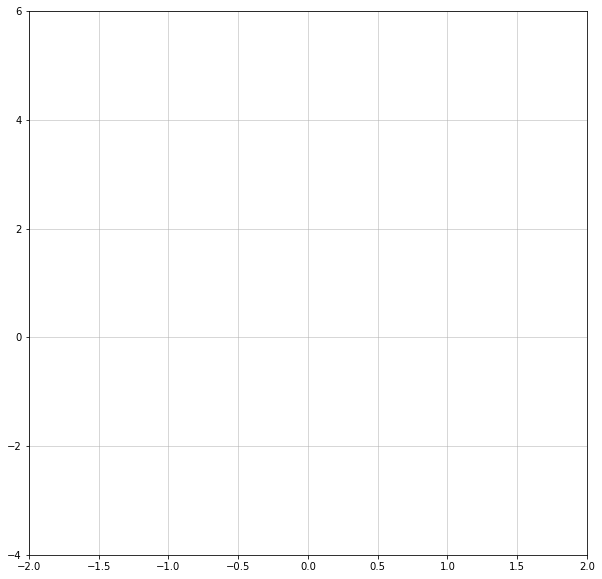

In [45]:
setup.makePlot(torch.as_tensor(samples),device)